In [1]:
from pathlib import Path
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import xarray as xr
from datetime import datetime, timedelta
import string
from dataclasses import dataclass

In [2]:
# plotting settings
DATAROOT = Path("../data")
FIGROOT = Path("../fig")
FIGDPI = 600
FIGSUFFIX = ".pdf"

plt.style.use("seaborn-v0_8-colorblind")
plt.rcParams.update(
    {
        "savefig.pad_inches": 0.05 / 2.54,
        "grid.linewidth": 0.25,
        "axes.titlesize": 8,
        "axes.titlepad": 0.05,
        "axes.labelsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,
        "text.usetex": True,
    }
)

In [3]:
DATETIME_START = datetime(2013, 6, 20)
DATETIME_STOP = datetime(2013, 10, 1) + timedelta(seconds=1)

In [4]:
NEXP = 5

In [5]:
GAUGE_FILE = DATAROOT.joinpath("gauge_q_loc.csv")
gaugeinfo = pl.read_csv(GAUGE_FILE)
gaugenames = ["Lazi", "Nugesha", "Yangcun", "Nuxia"]

In [6]:
QOBS_FILE = DATAROOT.joinpath("gauge_q_obs.parquet")
qobs = pl.read_parquet(QOBS_FILE)
qobs = qobs.filter(
    (qobs["tm"] >= DATETIME_START) & (qobs["tm"] < DATETIME_STOP)
)
qobs.head(n=0)

shape: (0, 5)
┌──────────────┬──────┬─────────┬─────────┬───────┐
│ tm           ┆ Lazi ┆ Nugesha ┆ Yangcun ┆ Nuxia │
│ ---          ┆ ---  ┆ ---     ┆ ---     ┆ ---   │
│ datetime[ms] ┆ f32  ┆ f32     ┆ f32     ┆ f32   │
╞══════════════╪══════╪═════════╪═════════╪═══════╡
└──────────────┴──────┴─────────┴─────────┴───────┘

In [7]:
celerity_opt = pl.read_csv(DATAROOT.joinpath("celerity_optimal.csv"))

In [8]:
@dataclass
class Skill:
    kge: float
    g: tuple[float, float, float]
    alpha: float
    beta: float
    rho: float
    nse: float

def calculate_skill(obs, sim):
    beta = sim.mean() / obs.mean()
    alpha = sim.std() / obs.std()
    rho = np.corrcoef(obs, sim)[0, 1]
    s = (1 - rho) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2
    kge = 1.0 - float(np.sqrt(s))
    g = (float((alpha -1)**2 / s), float((beta -1)**2 / s), float((rho -1)**2 / s))
    nse = 1 - float(np.sum(np.pow(sim - obs, 2)) / np.sum(np.pow(obs - obs.mean(), 2)))
    return Skill(kge, g, alpha, beta, rho, nse)

In [9]:
WRF_FILE = DATAROOT.joinpath("wrf_experiment.nc")
with h5netcdf.File(WRF_FILE) as f:
    lon = np.array(f["lon"], dtype=np.float64)
    lat = np.array(f["lat"], dtype=np.float64)
    mask = np.array(f['mask'], dtype=np.uint8)
prrn = xr.open_dataset(DATAROOT.joinpath("wrf_experiment.nc"), drop_variables=["mask"])
prrn = prrn.sel(time=slice(DATETIME_START, DATETIME_STOP))

In [10]:
def plot_yj(ax):
    ax.contour(lon, lat, mask, levels=[0.5, 1.5, 2.5, 3.5], linewidths=0.5, colors='white')
    ax.set_xticks([82, 86, 90, 94])
    ax.set_xticklabels(["82°E", "86°E", "90°E", "94°E"])
    ax.set_yticks([28, 29, 30, 31])
    ax.set_yticklabels(["28°N", "29°N", "30°N", "31°N"])
    ax.set_aspect("equal")

# WRF experiments

/Users/zhenghui/work/paper-yj-wrf-streamflow/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


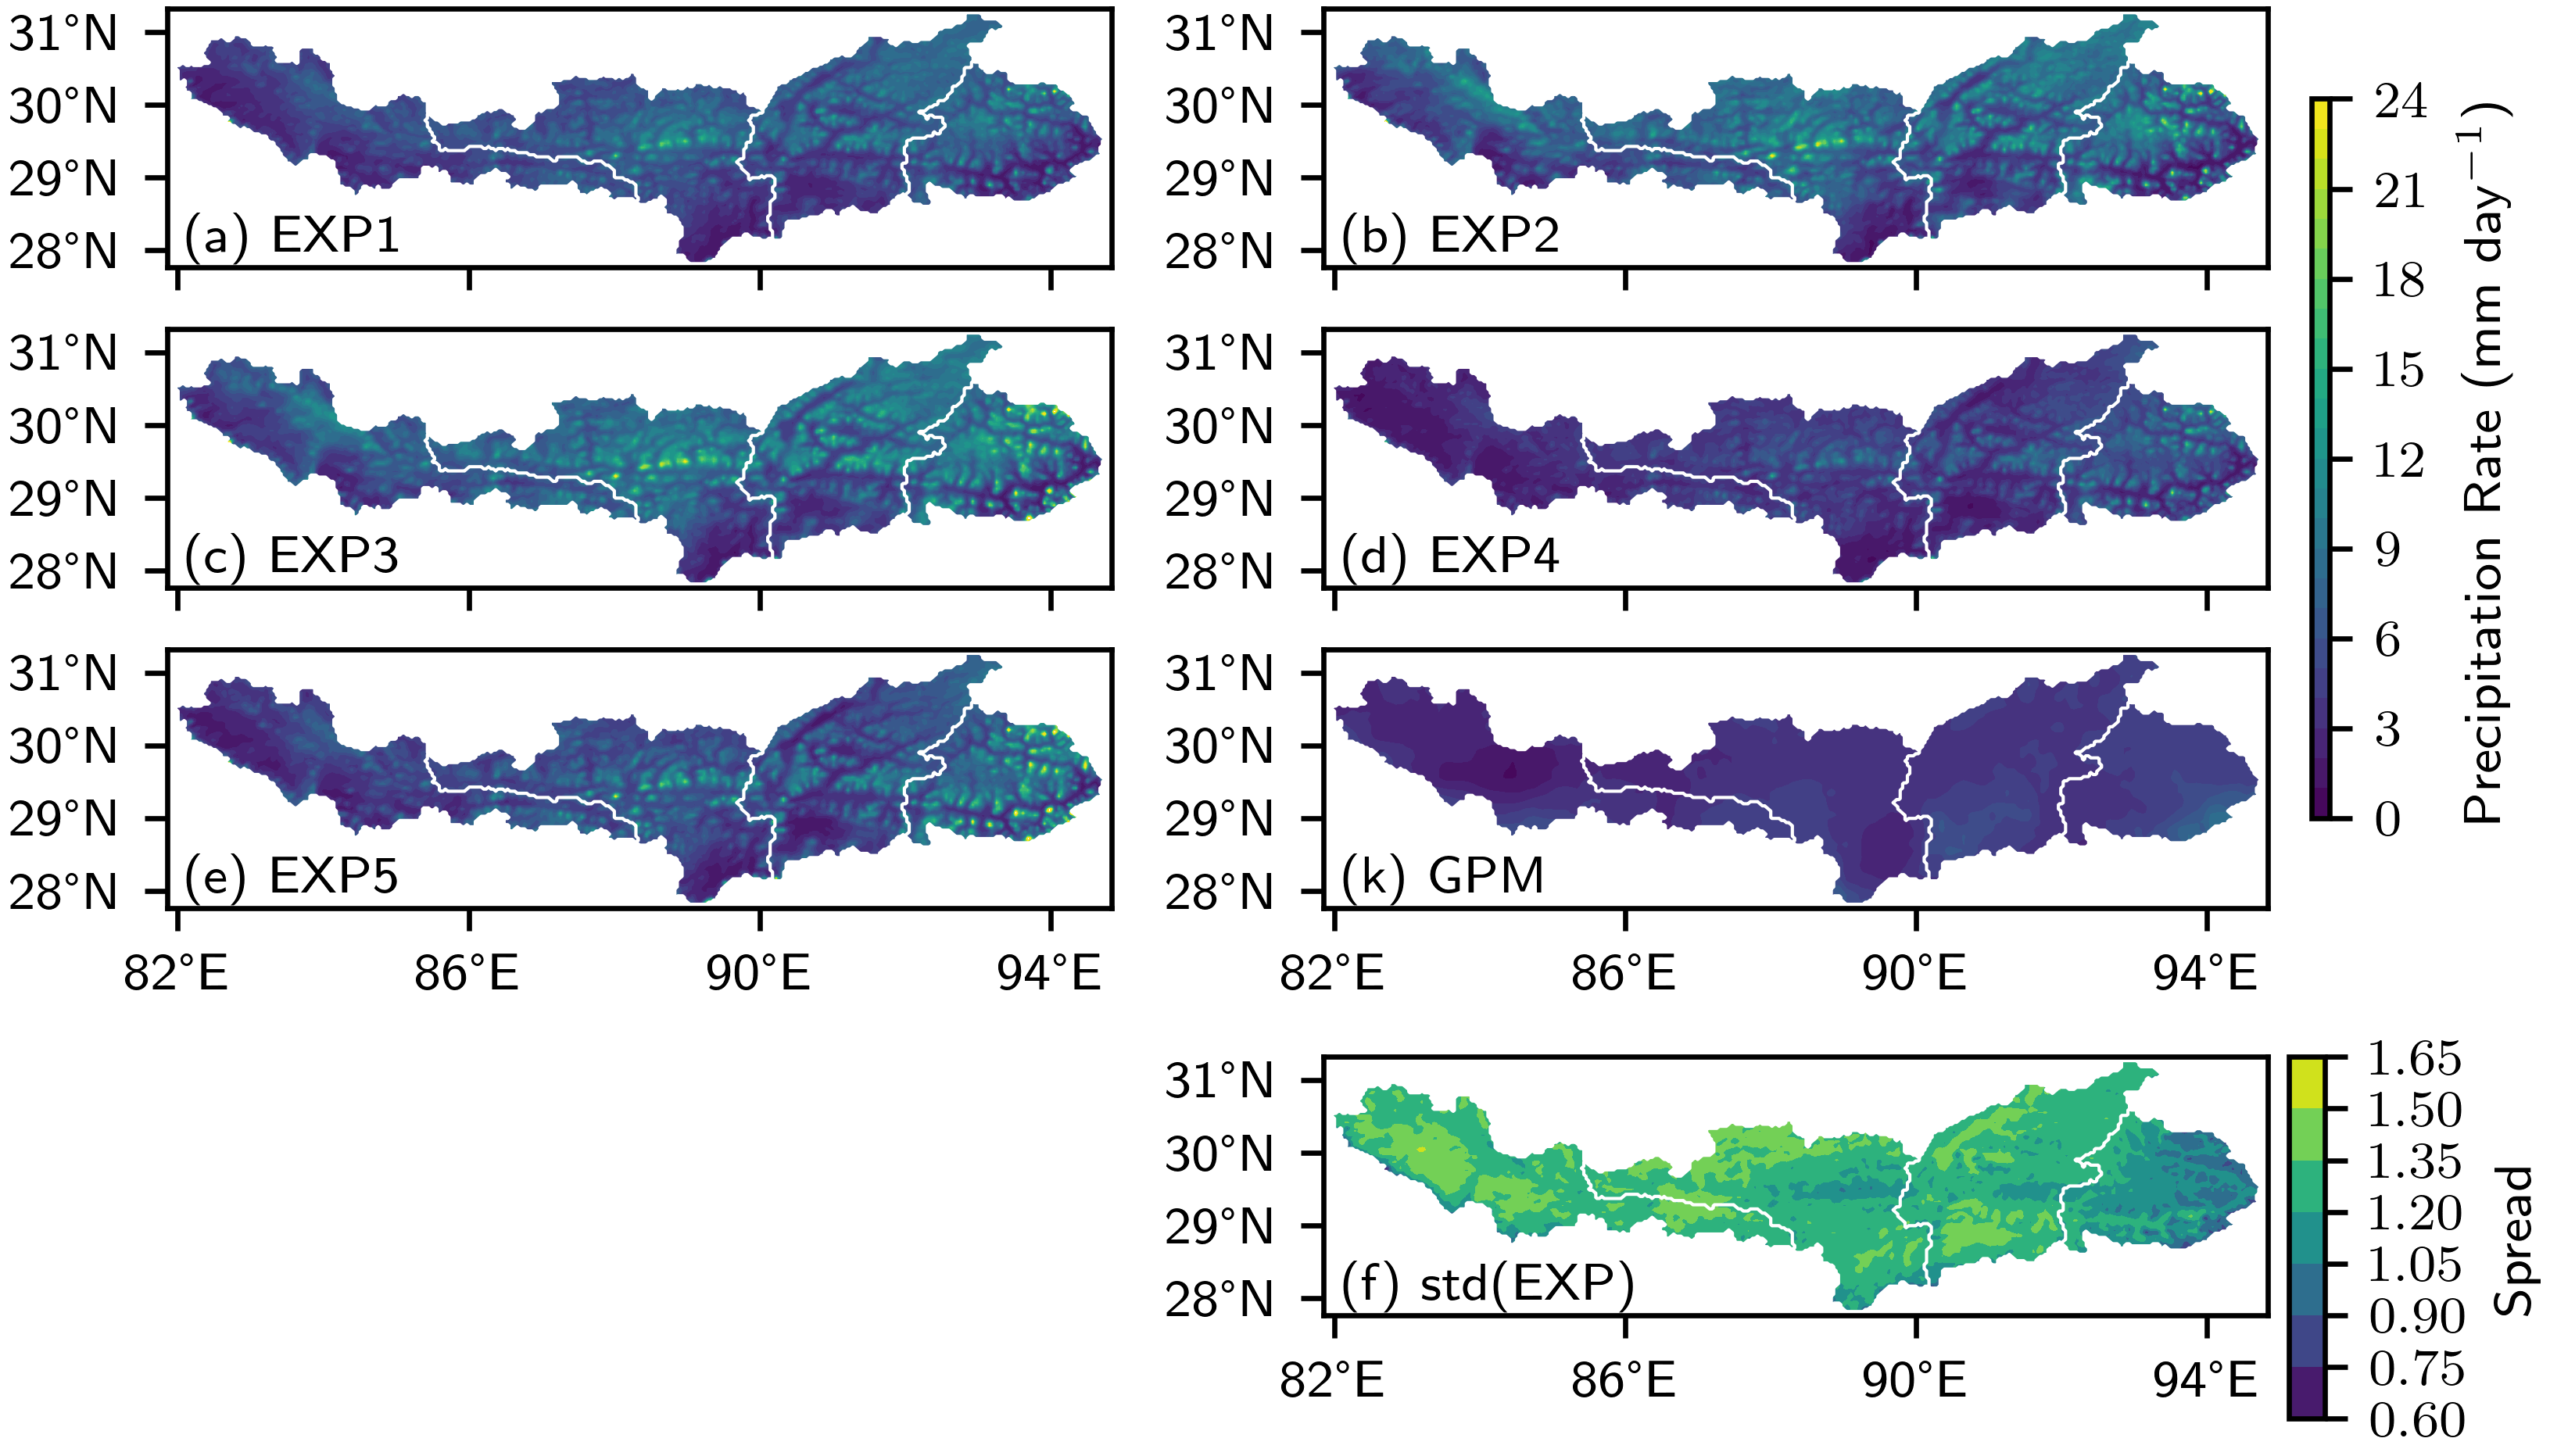

In [11]:
fig = plt.figure(figsize=(14/2.54, 8/2.54), dpi=FIGDPI, layout='constrained')

axs = fig.subplots(4, 2, squeeze=False)

levels = np.arange(0, 25, 1)

for iens in range(5):
    ax = axs.flat[iens]
    cf = ax.contourf(lon, lat, prrn['pr'].sel(ensemble=iens).mean('time') * (3600 * 24), levels=levels)
    ax.text(0.02, 0.01, f"({string.ascii_lowercase[iens]}) EXP{iens+1}", fontsize=8, transform=ax.transAxes, va='bottom', ha='left')
    plot_yj(ax)
    if iens % 2 == 1:
        ax.set_xticklabels([])
    elif iens // 2 != 2:
        ax.set_xticklabels([])

ax = axs.flat[5]
cf = ax.contourf(lon, lat, prrn['gpm'].mean('time') * (3600 * 24), levels=levels)
plot_yj(ax)
ax.text(0.02, 0.01, f"({string.ascii_lowercase[5 * 2]}) GPM", fontsize=8, transform=ax.transAxes, va='bottom', ha='left')

plt.colorbar(cf, ax=axs[0:3, :], label="Precipitation Rate (mm day$^{-1}$)", shrink=0.8, aspect=40, pad=0.02)

ax = axs[3, 1]
cfs = ax.contourf(lon, lat, prrn['pr'].std('ensemble').mean('time') / prrn['pr'].mean(['ensemble', 'time']))
plot_yj(ax)

plt.colorbar(cfs, ax=ax, label="Spread", anchor=(0, 1), shrink=1.4, aspect=10, pad=0.02)
ax.text(0.02, 0.01, f"({string.ascii_lowercase[5]}) std(EXP)", fontsize=8, transform=ax.transAxes, va='bottom', ha='left')

axs[3, 0].set_visible(False)

fig.savefig(FIGROOT.joinpath("prrn_prdist").with_suffix(FIGSUFFIX), bbox_inches='tight')

In [12]:
# spatial correlation coefficient
prscc : dict[str, list[float]] = {}
for igauge, gaugename in enumerate(gaugenames):
    prscc[gaugename] = []
    for iens in range(NEXP):
        xx = prrn['gpm'].mean('time').where(mask>0).to_numpy()
        yy = prrn['pr'].sel(ensemble=iens).mean('time').where(mask>0).to_numpy()
        valid = np.logical_and(np.isfinite(xx), np.isfinite(yy))
        valid = np.logical_and(valid, np.logical_and(mask > 0, mask <= igauge + 1))
        prscc[gaugename].append(float(np.corrcoef(xx[valid], yy[valid])[0, 1]))

In [13]:
xx = prrn['pr'].sel(ensemble=3).mean('time').where(mask>0).to_numpy()
yy = prrn['pr'].sel(ensemble=4).mean('time').where(mask>0).to_numpy()
valid = np.logical_and(np.isfinite(xx), np.isfinite(yy))
valid = np.logical_and(valid, mask > 0)
np.corrcoef(xx[valid], yy[valid])[0, 1]

np.float64(0.9345002075713542)

In [14]:
for gaugename in gaugenames:
    print(f"{gaugename}: {prscc[gaugename]}")

Lazi: [0.0016046477585584622, -0.19488384090691208, -0.05430816665923274, 0.24394170671774418, 0.15197118550670558]
Nugesha: [0.1622696964735385, 0.038075522092120506, 0.13457129915333169, 0.29064733080389815, 0.2538168768248585]
Yangcun: [0.11220353074322455, 0.0064913739818655836, 0.06434204139131512, 0.22247767256567924, 0.1713364272254202]
Nuxia: [0.04593352008564558, -0.04539264126230242, 0.08172550892707722, 0.279432316967243, 0.28323094708877466]


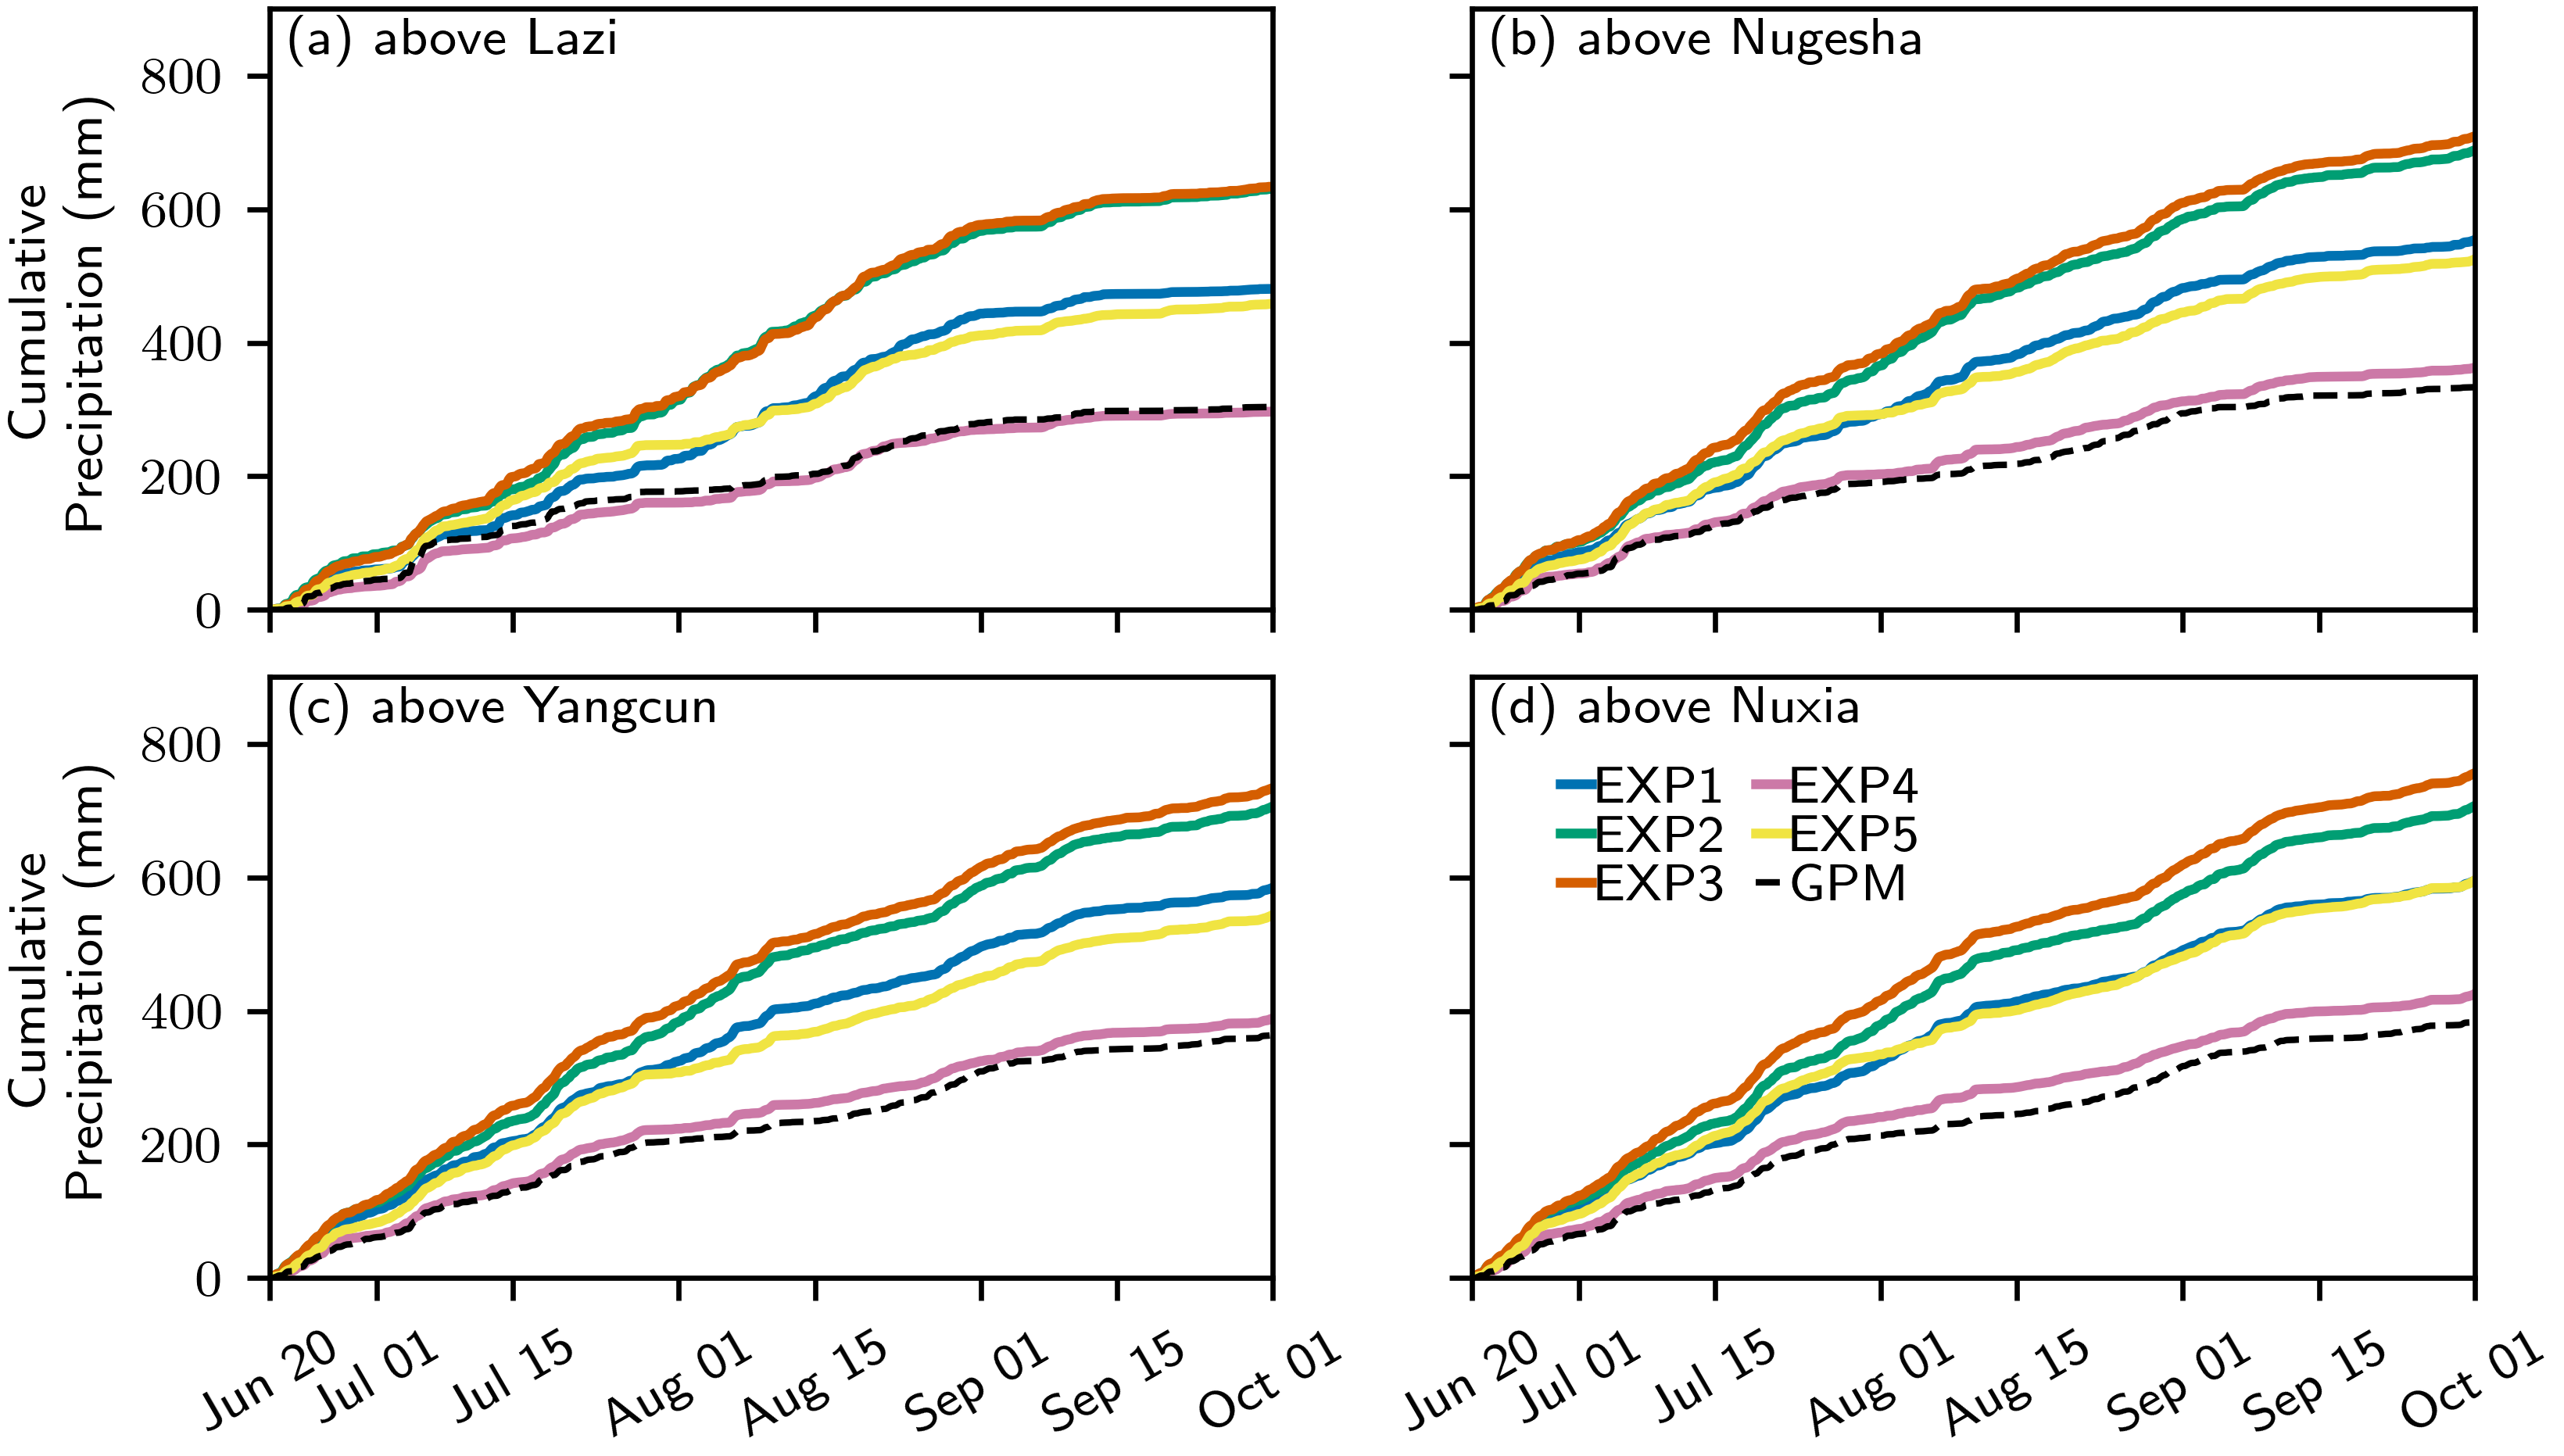

In [15]:
fig = plt.figure(figsize=(14/2.54, 8/2.54), dpi=FIGDPI, layout='constrained')
axs = fig.subplots(2, 2, sharex=True, sharey=True, squeeze=False)

labels = ["(a) above Lazi", "(b) above Nugesha", "(c) above Yangcun", "(d) above Nuxia"]

for igauge in range(4):
    ax = axs[igauge//2, igauge % 2]
    for iens in range(5):
        ax.plot(prrn['time'], prrn['pr'].sel(ensemble=iens).where(np.expand_dims(np.logical_and(mask>0, mask<=igauge+1), axis=0)).mean(['lat', 'lon']).cumsum('time') * 3600.0, label=f"EXP{iens+1}")
    ax.plot(prrn['time'], prrn['gpm'].where(np.expand_dims(np.logical_and(mask>0, mask<=igauge+1), axis=0)).mean(['lat', 'lon']).cumsum('time') * 3600.0, color='k', linestyle='--', linewidth=1, label="GPM")

    ax.set_xlim(DATETIME_START, DATETIME_STOP)
    ax.set_ylim(0, 900)
    ax.xaxis.set_tick_params(rotation=30)
    ax.xaxis.set_ticks([datetime(2013, 6, 20), datetime(2013, 7, 1), datetime(2013, 7, 15), datetime(2013, 8, 1), datetime(2013, 8, 15), datetime(2013, 9, 1), datetime(2013, 9,15), datetime(2013, 10, 1)])
    ax.xaxis.set_ticklabels(["Jun 20", "Jul 01", "Jul 15", "Aug 01", "Aug 15", "Sep 01", "Sep 15", "Oct 01"])

    ax.text(0.02, 0.99, labels[igauge], transform=ax.transAxes, fontsize=8, va='top', ha='left')


axs[0, 0].set_ylabel("Cumulative\nPrecipitation (mm)")
axs[1, 0].set_ylabel("Cumulative\nPrecipitation (mm)")
axs[1, 1].legend(loc='upper left', ncol=2, columnspacing=0.5, borderpad=1.2, labelspacing=0.05, handlelength=0.6, handletextpad=0.1, frameon=False, fontsize=8)

fig.savefig(FIGROOT.joinpath("prrn_prcumupts").with_suffix(FIGSUFFIX), bbox_inches='tight')

In [16]:
labels = ['above Lazi', 'above Nugesha', 'above Yangcun', 'above Nuxia']
prskills: dict[str, list[Skill]] = {}

for igauge, gaugename in enumerate(gaugenames):
    prskills[gaugename] = []
    for iens in range(NEXP):
        sim = prrn['pr'].sel(ensemble=iens).where(np.logical_and(mask>0, mask<=igauge+1)).mean(['lat', 'lon']).to_numpy()
        obs = prrn['gpm'].where(np.logical_and(mask>0, mask<=igauge+1)).mean(['lat', 'lon']).to_numpy()
        valid = np.logical_and(np.isfinite(sim), np.isfinite(obs))
        prskills[gaugename].append(calculate_skill(obs[valid], sim[valid]))


In [17]:
for iens in range(NEXP):
    for igauge, gaugename in enumerate(gaugenames):
        print(f"EXP{iens+1} {labels[igauge]}: KGE={prskills[gaugename][-1].kge:.2f}, alpha={prskills[gaugename][-1].alpha:.2f}, beta={prskills[gaugename][-1].beta:.2f}, rho={prskills[gaugename][-1].rho:.2f}")
    print()

EXP1 above Lazi: KGE=0.39, alpha=0.94, beta=1.51, rho=0.67
EXP1 above Nugesha: KGE=0.35, alpha=1.11, beta=1.57, rho=0.72
EXP1 above Yangcun: KGE=0.42, alpha=1.09, beta=1.49, rho=0.71
EXP1 above Nuxia: KGE=0.38, alpha=1.14, beta=1.55, rho=0.74

EXP2 above Lazi: KGE=0.39, alpha=0.94, beta=1.51, rho=0.67
EXP2 above Nugesha: KGE=0.35, alpha=1.11, beta=1.57, rho=0.72
EXP2 above Yangcun: KGE=0.42, alpha=1.09, beta=1.49, rho=0.71
EXP2 above Nuxia: KGE=0.38, alpha=1.14, beta=1.55, rho=0.74

EXP3 above Lazi: KGE=0.39, alpha=0.94, beta=1.51, rho=0.67
EXP3 above Nugesha: KGE=0.35, alpha=1.11, beta=1.57, rho=0.72
EXP3 above Yangcun: KGE=0.42, alpha=1.09, beta=1.49, rho=0.71
EXP3 above Nuxia: KGE=0.38, alpha=1.14, beta=1.55, rho=0.74

EXP4 above Lazi: KGE=0.39, alpha=0.94, beta=1.51, rho=0.67
EXP4 above Nugesha: KGE=0.35, alpha=1.11, beta=1.57, rho=0.72
EXP4 above Yangcun: KGE=0.42, alpha=1.09, beta=1.49, rho=0.71
EXP4 above Nuxia: KGE=0.38, alpha=1.14, beta=1.55, rho=0.74

EXP5 above Lazi: KGE=0.3

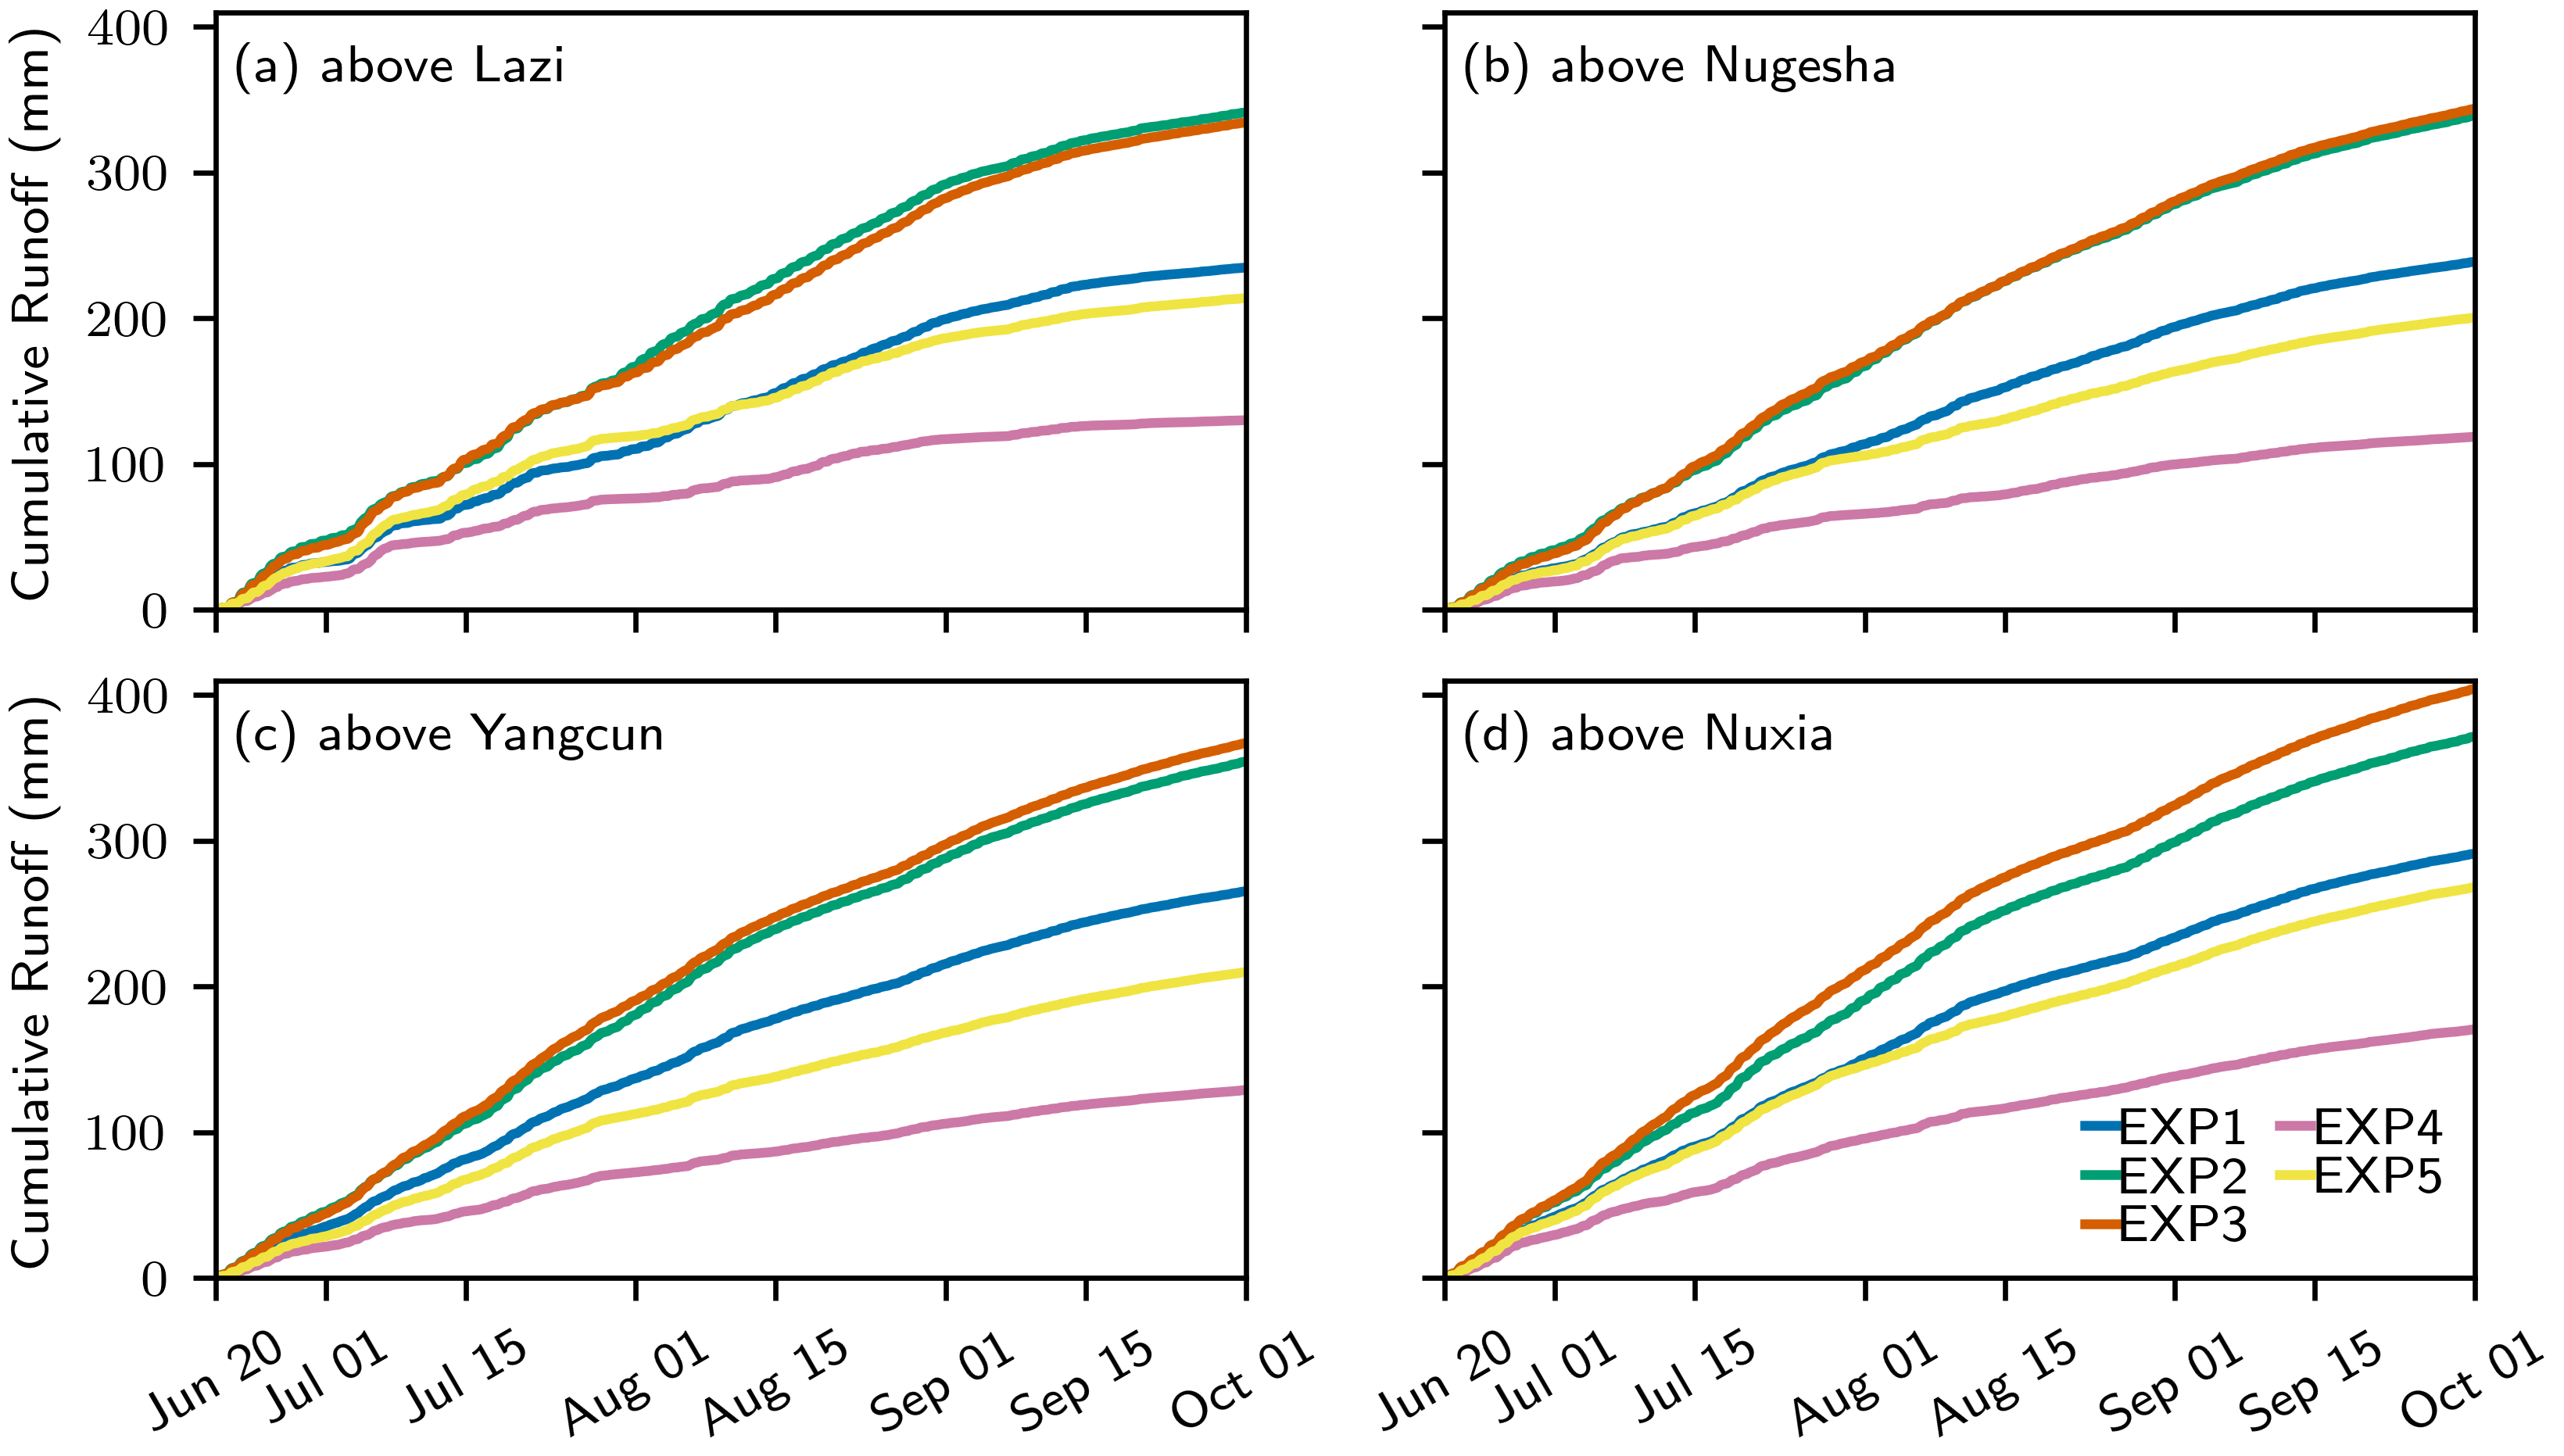

In [18]:
fig = plt.figure(figsize=(14/2.54, 8/2.54), dpi=FIGDPI, layout='constrained')
axs = fig.subplots(2, 2, sharex=True, sharey=True, squeeze=False)

labels = ["(a) above Lazi", "(b) above Nugesha", "(c) above Yangcun", "(d) above Nuxia"]

for igauge in range(4):
    ax = axs[igauge//2, igauge % 2]
    for iens in range(5):
        ax.plot(prrn['time'], prrn['mrro'].sel(ensemble=iens).where(np.logical_and(mask>0, mask<=igauge+1)).mean(['lat', 'lon']).cumsum() * 3600.0, label=f"EXP{iens+1}")

    ax.set_xlim(DATETIME_START, DATETIME_STOP)
    ax.set_ylim(0, 410)
    ax.xaxis.set_tick_params(rotation=30)
    ax.xaxis.set_ticks([datetime(2013, 6, 20), datetime(2013, 7, 1), datetime(2013, 7, 15), datetime(2013, 8, 1), datetime(2013, 8, 15), datetime(2013, 9, 1), datetime(2013, 9,15), datetime(2013, 10, 1)])
    ax.xaxis.set_ticklabels(["Jun 20", "Jul 01", "Jul 15", "Aug 01", "Aug 15", "Sep 01", "Sep 15", "Oct 01"])

    ax.text(0.02, 0.95, labels[igauge], transform=ax.transAxes, fontsize=8, va='top', ha='left')


axs[0, 0].set_ylabel("Cumulative Runoff (mm)")
axs[1, 0].set_ylabel("Cumulative Runoff (mm)")
axs[1, 1].legend(loc='lower right', ncol=2, columnspacing=0.5, borderpad=0, labelspacing=0.05, handlelength=0.6, handletextpad=0.1, frameon=False, fontsize=8)

fig.savefig(FIGROOT.joinpath("prrn_rncumupts").with_suffix(FIGSUFFIX), bbox_inches='tight')

/Users/zhenghui/work/paper-yj-wrf-streamflow/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


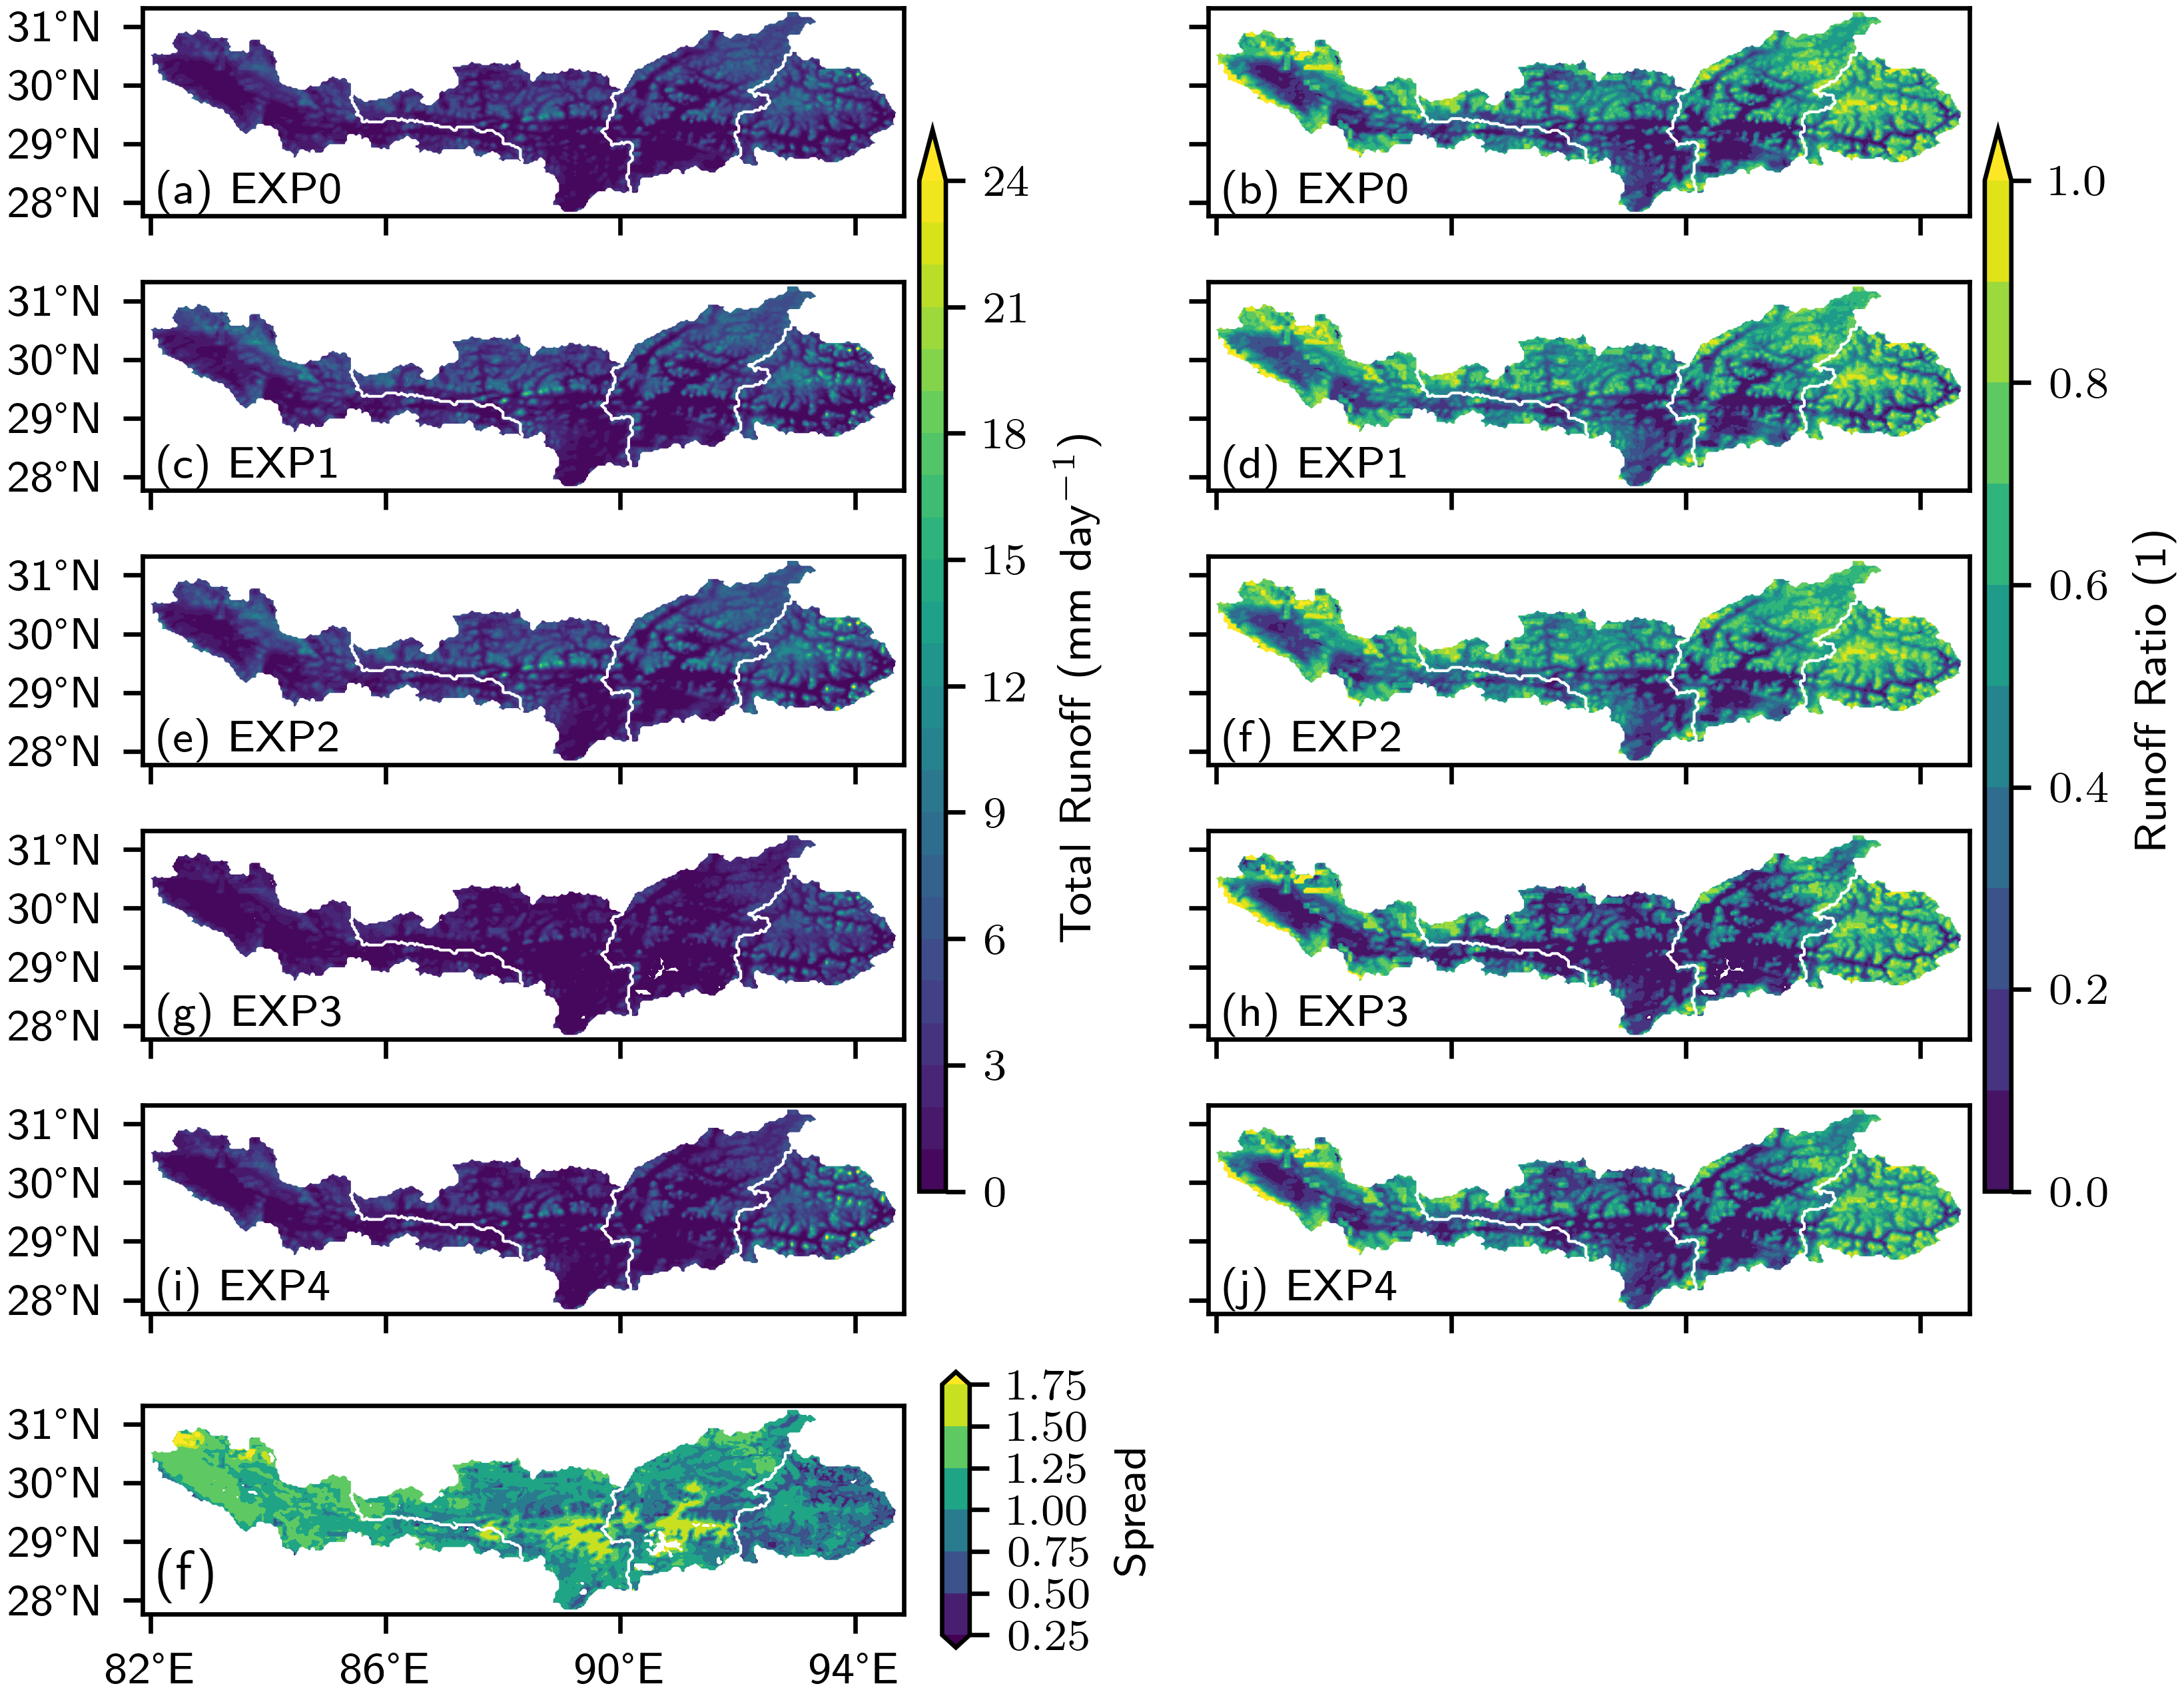

In [19]:
fig = plt.figure(figsize=(14/2.54, 11/2.54), dpi=FIGDPI, layout='constrained')
axs = fig.subplots(6, 2, sharex=True, sharey=True, squeeze=False)

levels = np.arange(0, 25, 1)
levels_ratio = np.arange(0, 1.01, 0.1)

for iens in range(5):
    ax = axs[iens, 0]
    cf = ax.contourf(lon, lat, prrn['mrro'].sel(ensemble=iens).mean('time') * (3600 * 24), levels=levels, extend='max')
    ax.text(0.02, 0.01, f"({string.ascii_lowercase[iens*2]}) EXP{iens}", fontsize=8, transform=ax.transAxes, va='bottom', ha='left')
    plot_yj(ax)

    ax = axs[iens, 1]
    cfr = ax.contourf(lon, lat, prrn['mrro'].sel(ensemble=iens).mean('time') / prrn['pr'].sel(ensemble=iens).mean('time'), levels=levels_ratio, extend='max')
    ax.text(0.02, 0.01, f"({string.ascii_lowercase[iens*2+1]}) EXP{iens}", fontsize=8, transform=ax.transAxes, va='bottom', ha='left')
    plot_yj(ax)

plt.colorbar(cf, ax=axs[0:5, 0], label="Total Runoff (mm day$^{-1}$)", shrink=0.8, aspect=40, pad=0.02)
plt.colorbar(cfr, ax=axs[0:5, 1], label="Runoff Ratio (1)", shrink=0.8, aspect=40, pad=0.02)

ax = axs[5, 0]
cfs = ax.contourf(lon, lat, prrn['mrro'].std('ensemble').mean('time') / prrn['mrro'].mean(['ensemble', 'time']), extend='both', levels=np.arange(0.25, 1.76, 0.25))
plot_yj(ax)
ax.text(0.02, 0.05, f"({string.ascii_lowercase[5]})", transform=ax.transAxes, va='bottom', ha='left')

cb = plt.colorbar(cfs, ax=axs[5, 0], label="Spread", shrink=1.2, aspect=10)

ax = axs[5,1]
plot_yj(ax)
ax.set_visible(False)

fig.savefig(FIGROOT.joinpath("prrn_rnrrdist").with_suffix(FIGSUFFIX), bbox_inches='tight')

# Streamflow

In [20]:
QOUTROOT = DATAROOT.joinpath("qout")
rnskills: dict[str, list[list[Skill]]] = {}
celerity: dict[str, list[list[float]]] = {}

for gauge in gaugenames:
    rnskills[gauge] = [[] for _ in range(NEXP)]
    celerity[gauge] = [[] for _ in range(NEXP)]
    reach = str(gaugeinfo.filter(pl.col("gauge") == gauge).select(pl.col("reach")).item()).lower()
    qoutroot = QOUTROOT.joinpath(f"qout_{gauge.lower()}")
    for filepath in sorted(qoutroot.glob("exp*.parquet")):
        exp = int(filepath.stem.split("_")[0].removeprefix("exp"))
        celerity[gauge][exp].append(float(filepath.stem.split("_")[-1]))
        qout = pl.read_parquet(filepath)
        obssim = qobs["tm", gauge].join(qout["tm", reach], on='tm', how='inner').drop_nulls()
        rnskills[gauge][exp].append(calculate_skill(obssim[:, 1].to_numpy(), obssim[:, 2].to_numpy()))

In [21]:
labels = ['Lazi', 'Nugesha', 'Yangcun', 'Nuxia']
for iens in range(NEXP):
    for igauge, stname in enumerate(gaugenames):
        idx = celerity[stname][iens].index(celerity_opt[iens, stname])
        print(f"EXP{iens+1} {labels[igauge]}: KGE={rnskills[stname][iens][idx].kge:.2f}, alpha={rnskills[stname][iens][idx].alpha:.2f}, beta={rnskills[stname][iens][idx].beta:.2f}, rho={rnskills[stname][iens][idx].rho:.2f}")
    print()


EXP1 Lazi: KGE=-3.12, alpha=3.76, beta=4.05, rho=0.81
EXP1 Nugesha: KGE=-0.16, alpha=1.14, beta=2.14, rho=0.80
EXP1 Yangcun: KGE=0.01, alpha=1.26, beta=1.93, rho=0.79
EXP1 Nuxia: KGE=0.54, alpha=1.06, beta=1.40, rho=0.79

EXP2 Lazi: KGE=-5.34, alpha=4.88, beta=6.00, rho=0.73
EXP2 Nugesha: KGE=-1.16, alpha=1.51, beta=3.08, rho=0.69
EXP2 Yangcun: KGE=-0.72, alpha=1.57, beta=2.60, rho=0.74
EXP2 Nuxia: KGE=0.19, alpha=1.23, beta=1.74, rho=0.76

EXP3 Lazi: KGE=-5.24, alpha=4.95, beta=5.82, rho=0.78
EXP3 Nugesha: KGE=-1.21, alpha=1.65, beta=3.11, rho=0.78
EXP3 Yangcun: KGE=-0.88, alpha=1.84, beta=2.67, rho=0.80
EXP3 Nuxia: KGE=-0.09, alpha=1.51, beta=1.95, rho=0.82

EXP4 Lazi: KGE=-1.78, alpha=3.46, beta=2.25, rho=0.65
EXP4 Nugesha: KGE=0.65, alpha=0.72, beta=1.07, rho=0.80
EXP4 Yangcun: KGE=0.69, alpha=0.77, beta=0.93, rho=0.81
EXP4 Nuxia: KGE=0.60, alpha=0.72, beta=0.81, rho=0.79

EXP5 Lazi: KGE=-3.59, alpha=4.71, beta=3.68, rho=0.69
EXP5 Nugesha: KGE=0.19, alpha=1.13, beta=1.79, rho=0.84


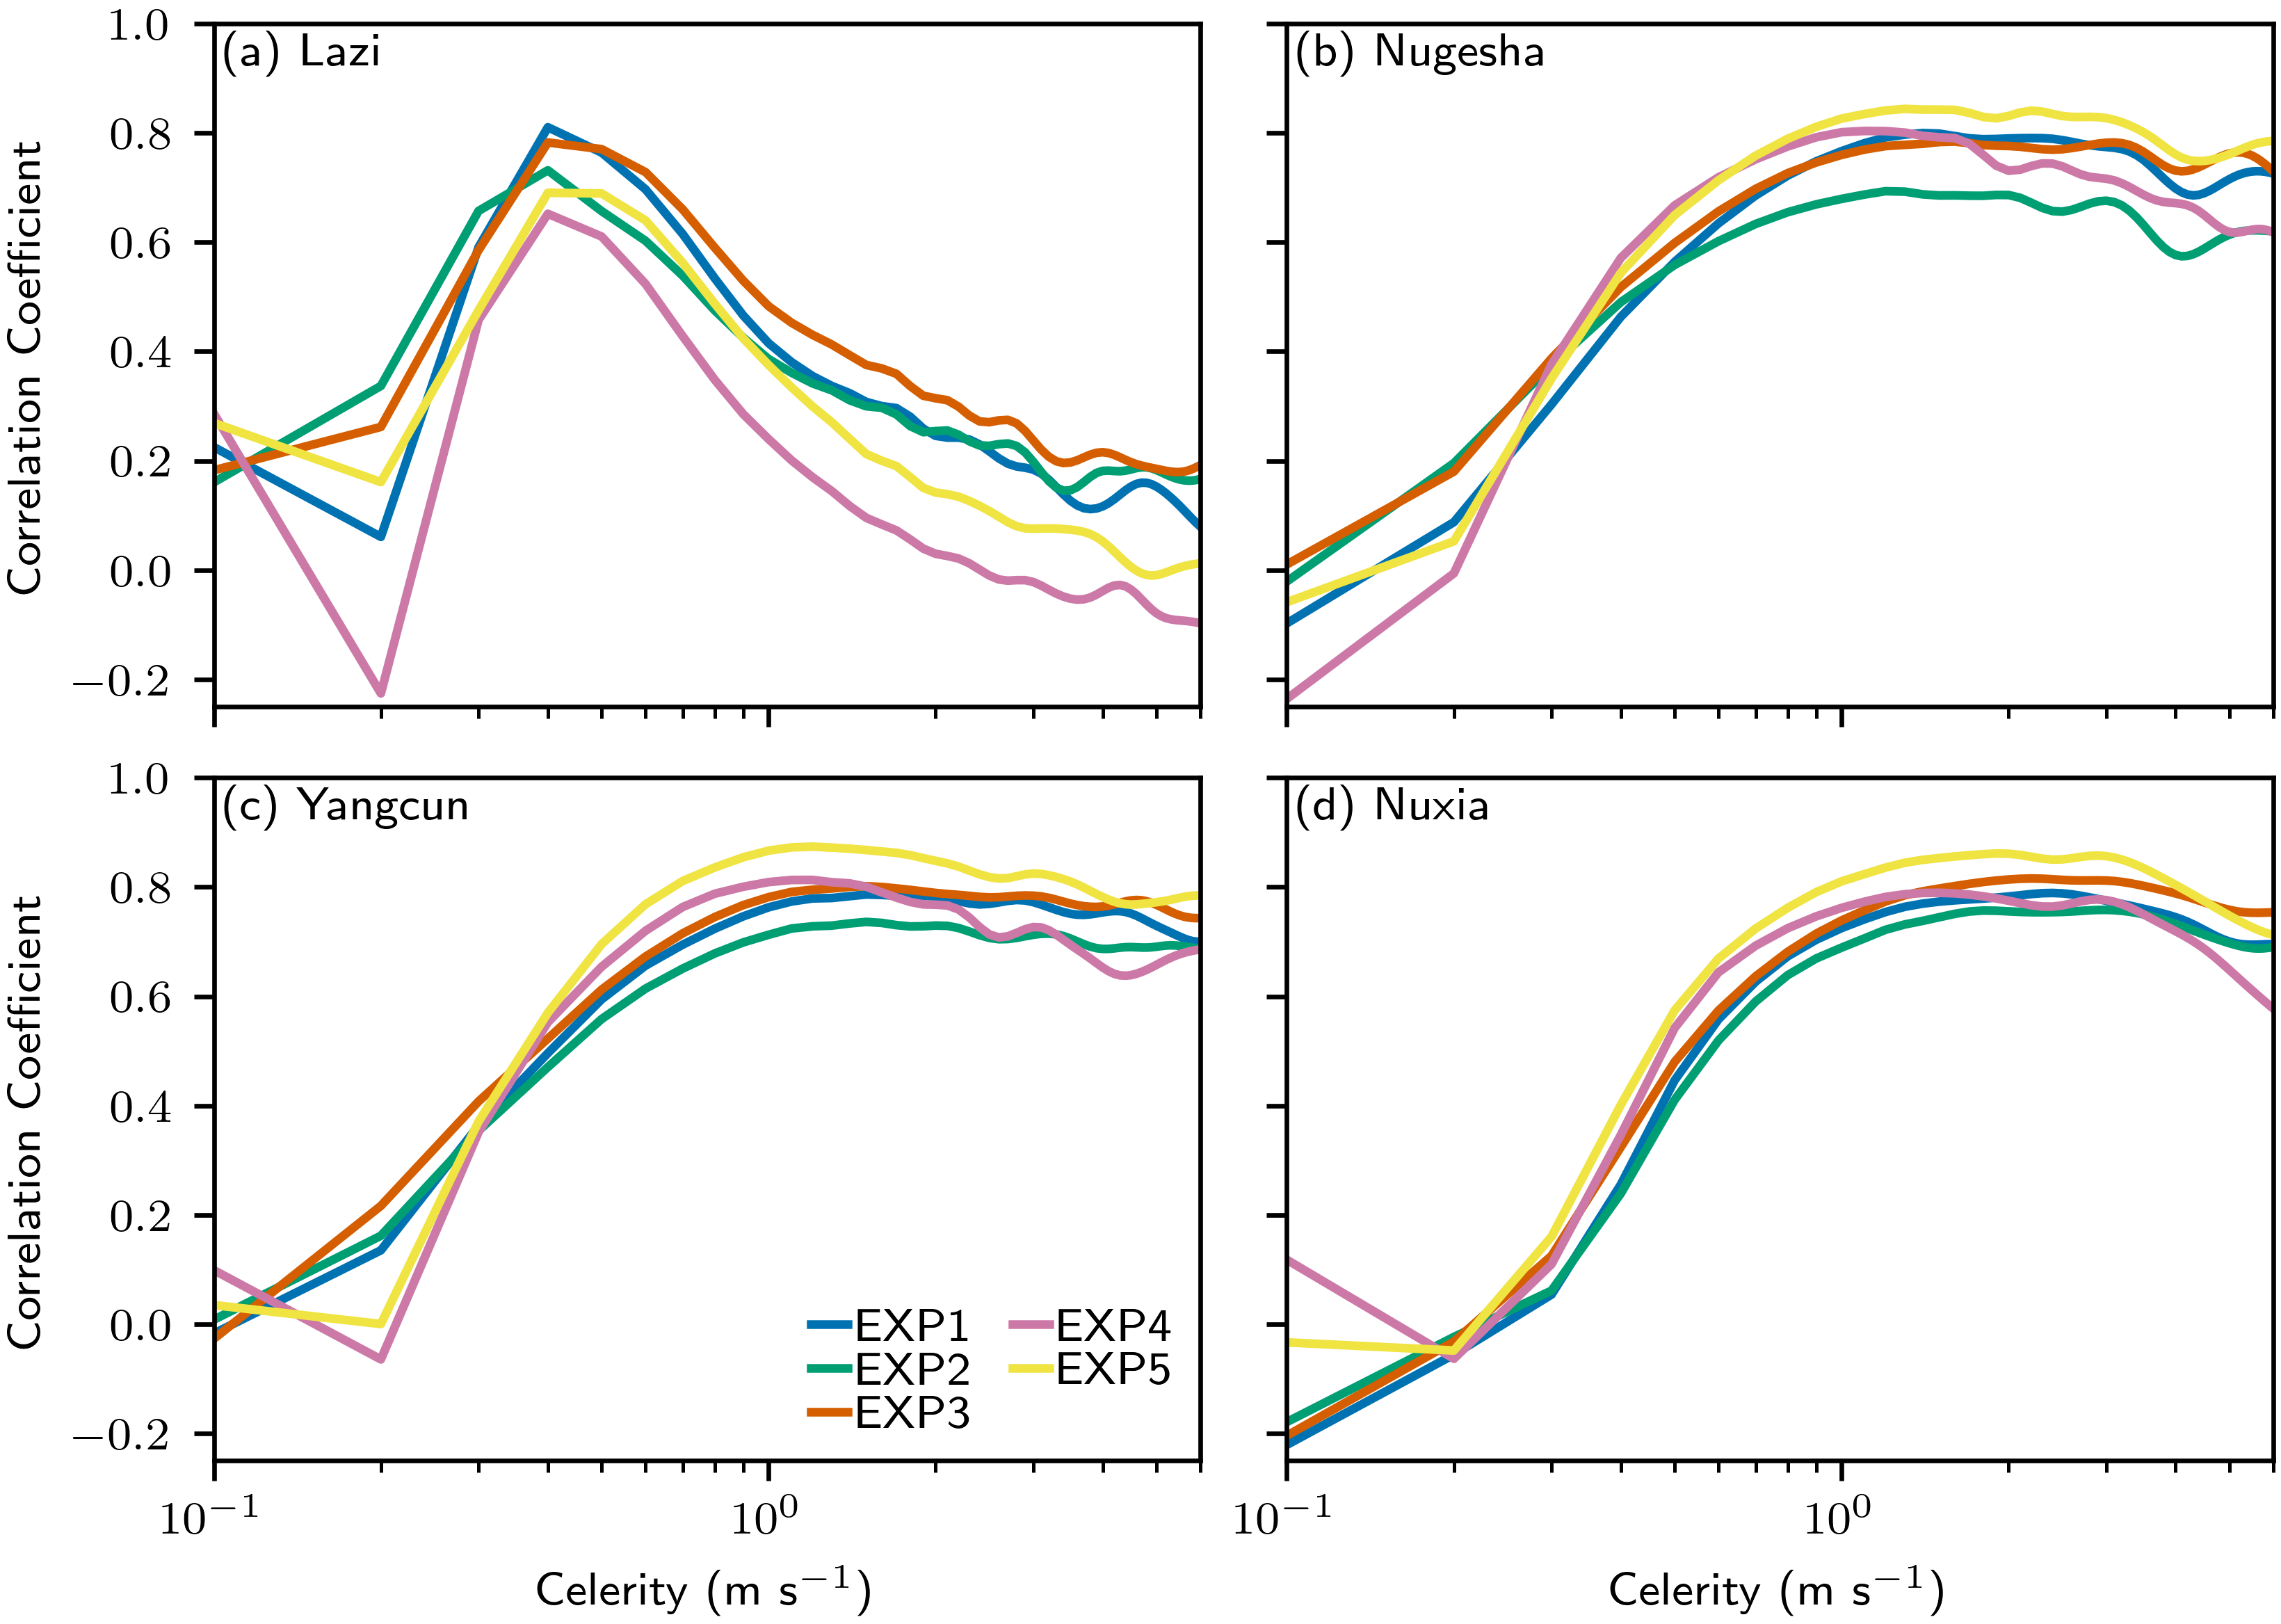

In [22]:
fig = plt.figure(figsize=(14/2.54, 10/2.54), dpi=FIGDPI, layout='constrained')
axs = fig.subplots(2, 2, sharex=True, sharey=True, squeeze=False)

labels = ['(a) Lazi', '(b) Nugesha', '(c) Yangcun', '(d) Nuxia']

for igauge, gaugename in enumerate(gaugenames):
    ax = axs.flat[igauge]
    for iens in range(5):
        ax.plot(celerity[gaugename][iens], [x.rho for x in rnskills[gaugename][iens]], label=f"EXP{iens+1}")
    ax.text(0.01, 0.99, labels[igauge], transform=ax.transAxes, fontsize=8, va='top', ha='left')

ax.set_ylim(-0.25, 1.0)
ax.set_xlim(0.1, 6.0)
ax.set_xscale('log')

axs[1, 0].set_xlabel("Celerity (m s$^{-1}$)")
axs[1, 1].set_xlabel("Celerity (m s$^{-1}$)")
axs[0, 0].set_ylabel("Correlation Coefficient")
axs[1, 0].set_ylabel("Correlation Coefficient")

axs[1, 0].legend(loc='lower right', ncol=2, columnspacing=0.8, borderpad=0.01, labelspacing=0.05, handlelength=0.8, handletextpad=0.2, frameon=False, fontsize=8, )

fig.savefig(FIGROOT.joinpath("q_sens_cc").with_suffix(FIGSUFFIX), bbox_inches='tight')

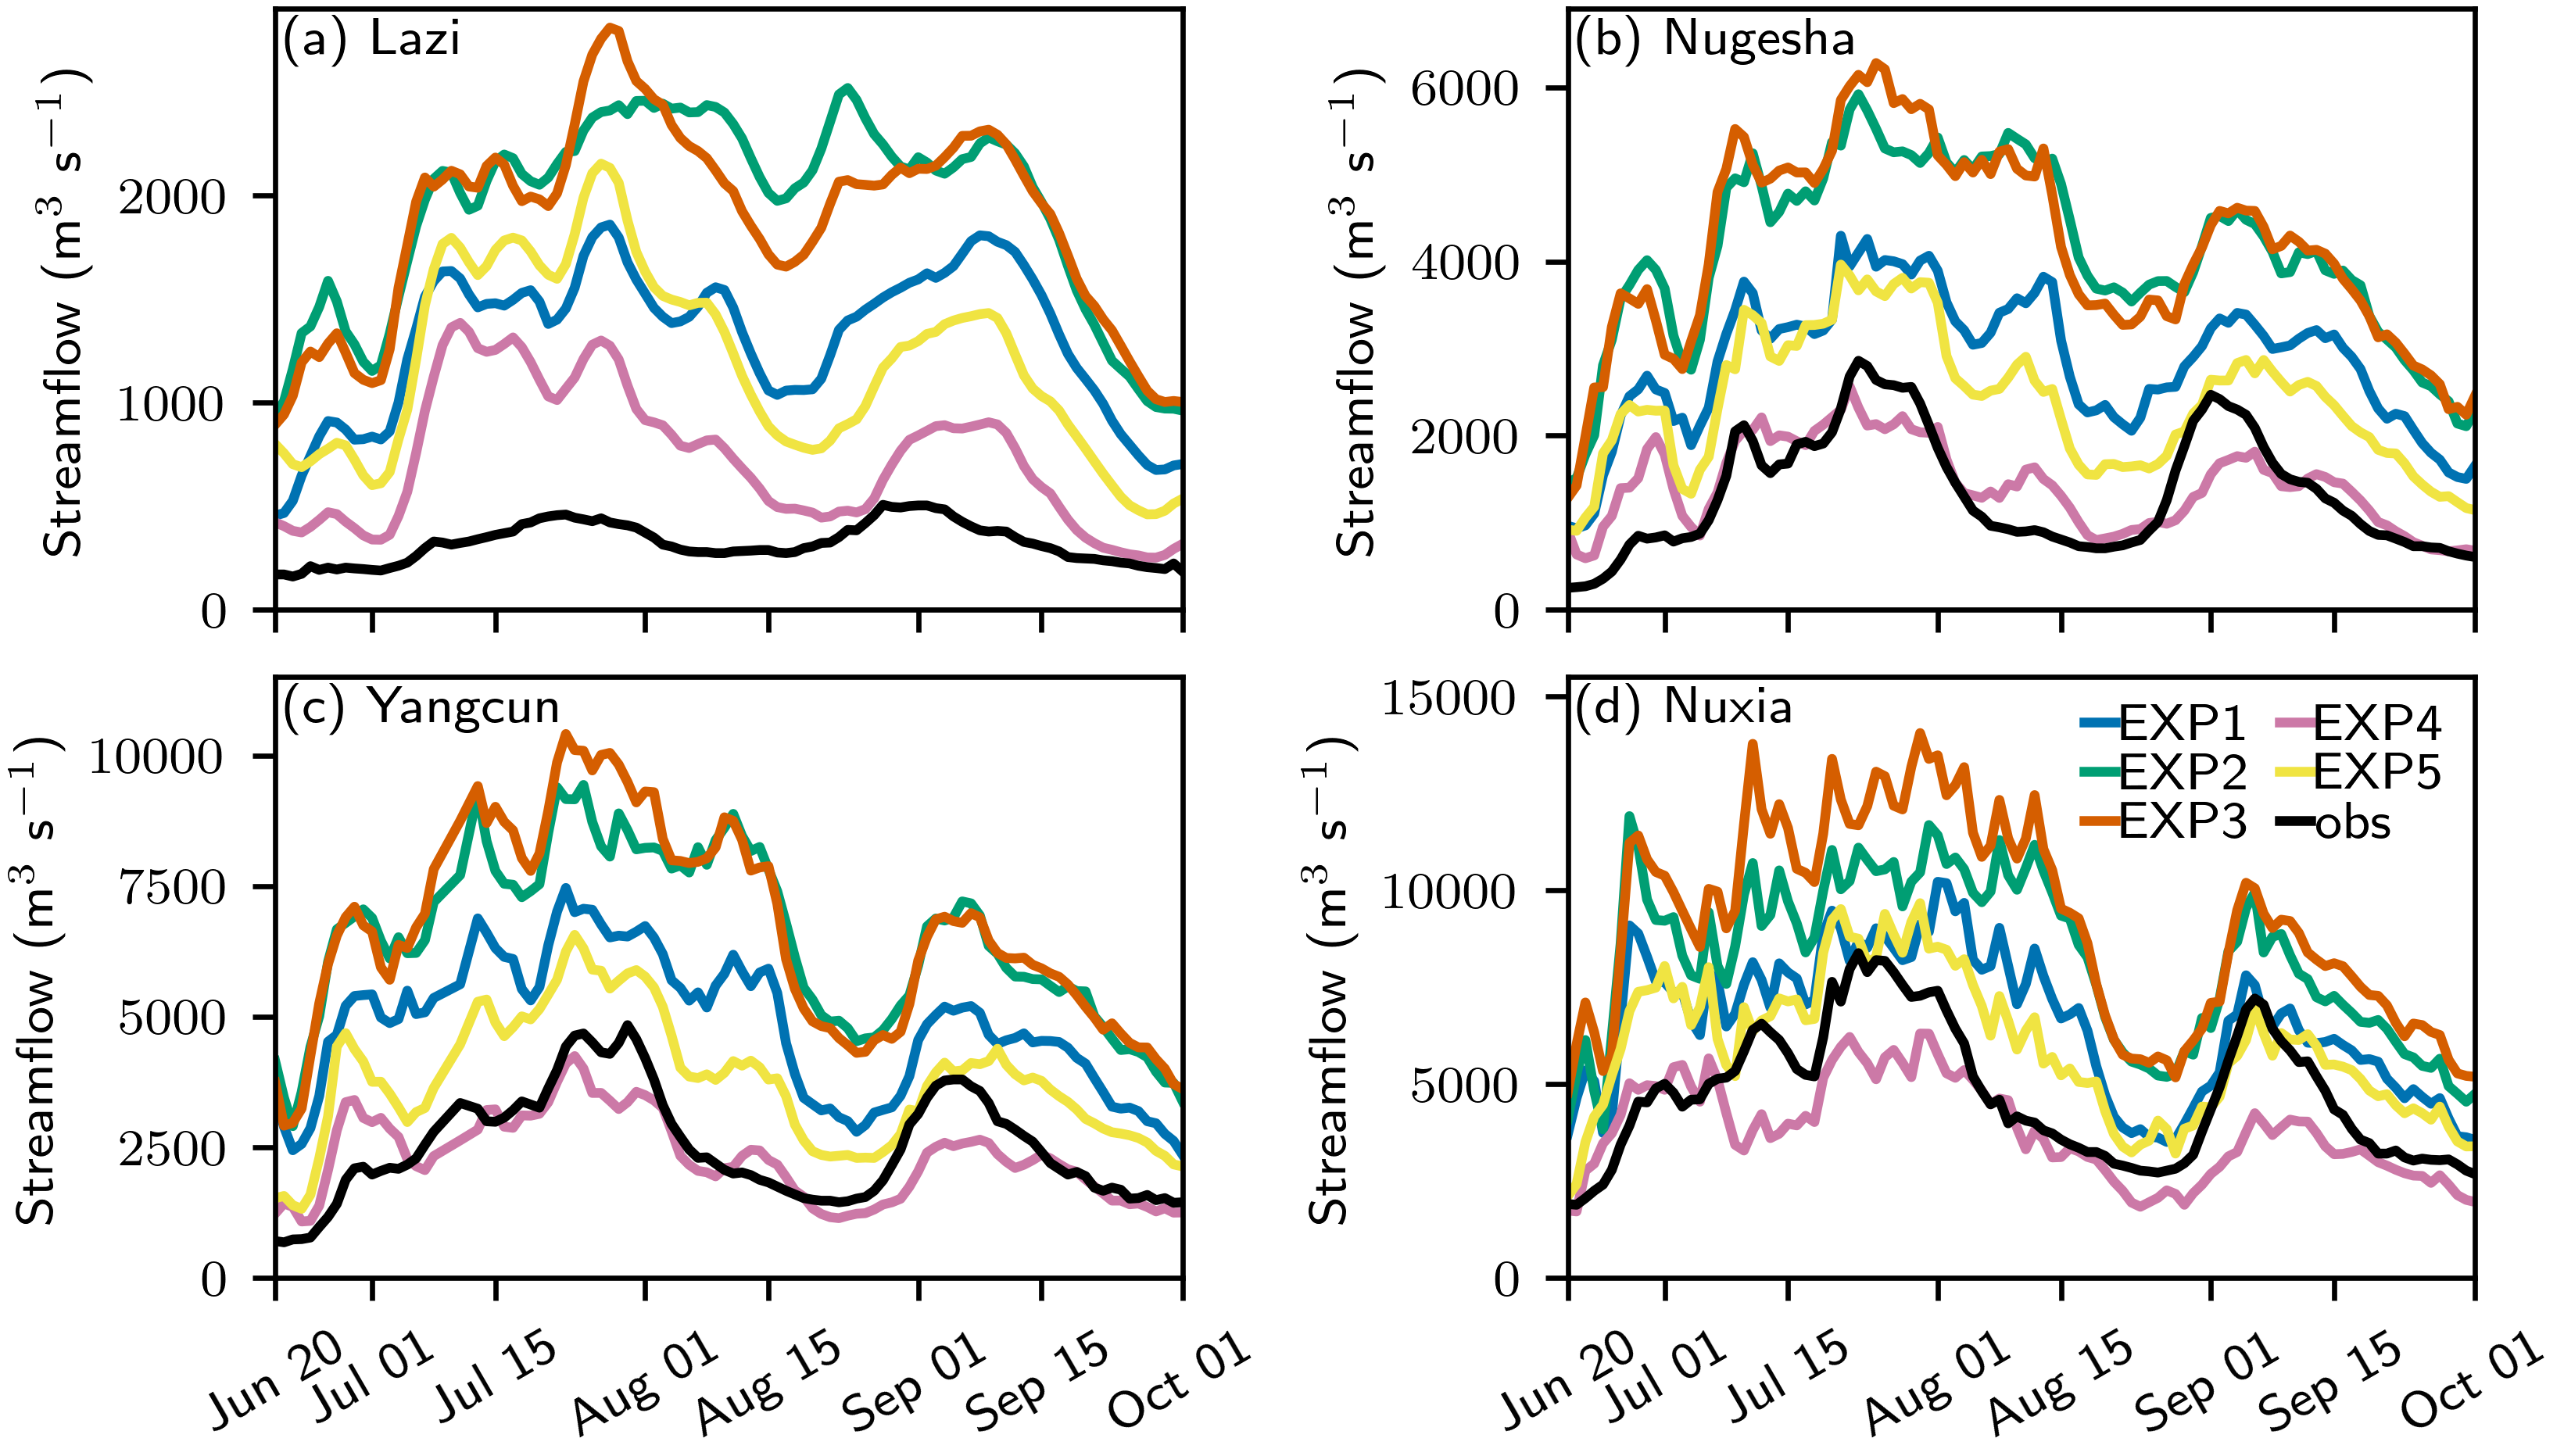

In [23]:
fig = plt.figure(figsize=(14/2.54, 8/2.54), dpi=FIGDPI, layout='constrained')
axs = fig.subplots(2, 2, sharex=True, squeeze=False)

labels = ['(a) Lazi', '(b) Nugesha', '(c) Yangcun', '(d) Nuxia']

qout_opt = []
for iens in range(NEXP):
    qoutfile = DATAROOT.joinpath("qout", "qout_nuxia", f"exp{iens}_{celerity_opt[iens, 'Nuxia']:.2f}.parquet")
    qout_opt.append(pl.read_parquet(qoutfile))

for igauge, gaugename in enumerate(gaugenames):
    ax = axs.flat[igauge]
    reach = str(gaugeinfo.filter(pl.col("gauge") == gaugename).select(pl.col("reach")).item()).lower()
    for iens in range(5):
        qobsout = qobs['tm', gaugename].join(qout_opt[iens]['tm', reach], on='tm', how='inner').drop_nulls()
        ax.plot(qobsout[:, 0], qobsout[:, 2], label=f"EXP{iens+1}")
    ax.plot(qobsout[:, 0], qobsout[:, 1], label="obs", color='k', linestyle='-')
    ax.set_xlim(DATETIME_START, DATETIME_STOP)
    ax.xaxis.set_tick_params(rotation=30)
    ax.xaxis.set_ticks([datetime(2013, 6, 20), datetime(2013, 7, 1), datetime(2013, 7, 15), datetime(2013, 8, 1), datetime(2013, 8, 15), datetime(2013, 9, 1), datetime(2013, 9,15), datetime(2013, 10, 1)])
    ax.xaxis.set_ticklabels(["Jun 20", "Jul 01", "Jul 15", "Aug 01", "Aug 15", "Sep 01", "Sep 15", "Oct 01"])
    ax.text(0.01, 0.99, labels[igauge], transform=ax.transAxes, fontsize=8, va='top', ha='left')
    ax.set_ylabel("Streamflow (m$^3$ s$^{-1}$)")

axs[0, 0].set_ylim(0, 2900)
axs[0, 1].set_ylim(0, 6900)
axs[1, 0].set_ylim(0, 11500)
axs[1, 1].set_ylim(0, 15500)
axs[1, 1].legend(loc='upper right', ncol=2, columnspacing=0.5, borderpad=0.01, labelspacing=0.05, handlelength=0.6, handletextpad=0.1, frameon=False, fontsize=8, )

fig.savefig(FIGROOT.joinpath("q_opt").with_suffix(FIGSUFFIX), bbox_inches='tight')

# Sensitivity

In [24]:
sens_pr: dict[str, list[float]] = {}
sens_rn: dict[str, list[float]] = {}
sens_sf: dict[str, list[float]] = {}
sens_gpm: dict[str, float] = {}
sens_sfo: dict[str, float] = {}

for igauge, gaugename in enumerate(gaugenames):
    sens_pr[gaugename] = []
    sens_rn[gaugename] = []
    sens_sf[gaugename] = []
    reach = str(gaugeinfo.filter(pl.col("gauge") == gauge).select(pl.col("reach")).item()).lower()
    for iens in range(NEXP):
        sens_pr[gaugename].append(float(prrn['pr'].sel(ensemble=iens).where(np.expand_dims(np.logical_and(mask>0, mask<=igauge+1), axis=0)).mean(['time', 'lat', 'lon']) * 3600.0))
        sens_rn[gaugename].append(float(prrn['mrro'].sel(ensemble=iens).where(np.expand_dims(np.logical_and(mask>0, mask<=igauge+1), axis=0)).mean(['time', 'lat', 'lon']) * 3600.0))
        sens_gpm[gaugename] = float(prrn['gpm'].where(np.expand_dims(np.logical_and(mask>0, mask<=igauge+1), axis=0)).mean(['time', 'lat', 'lon']) * 3600.0)
        sens_sf[gaugename].append(float(qout_opt[iens][reach].mean()))
        sens_sfo[gaugename] = float(qobs[gaugename].mean())
        pass


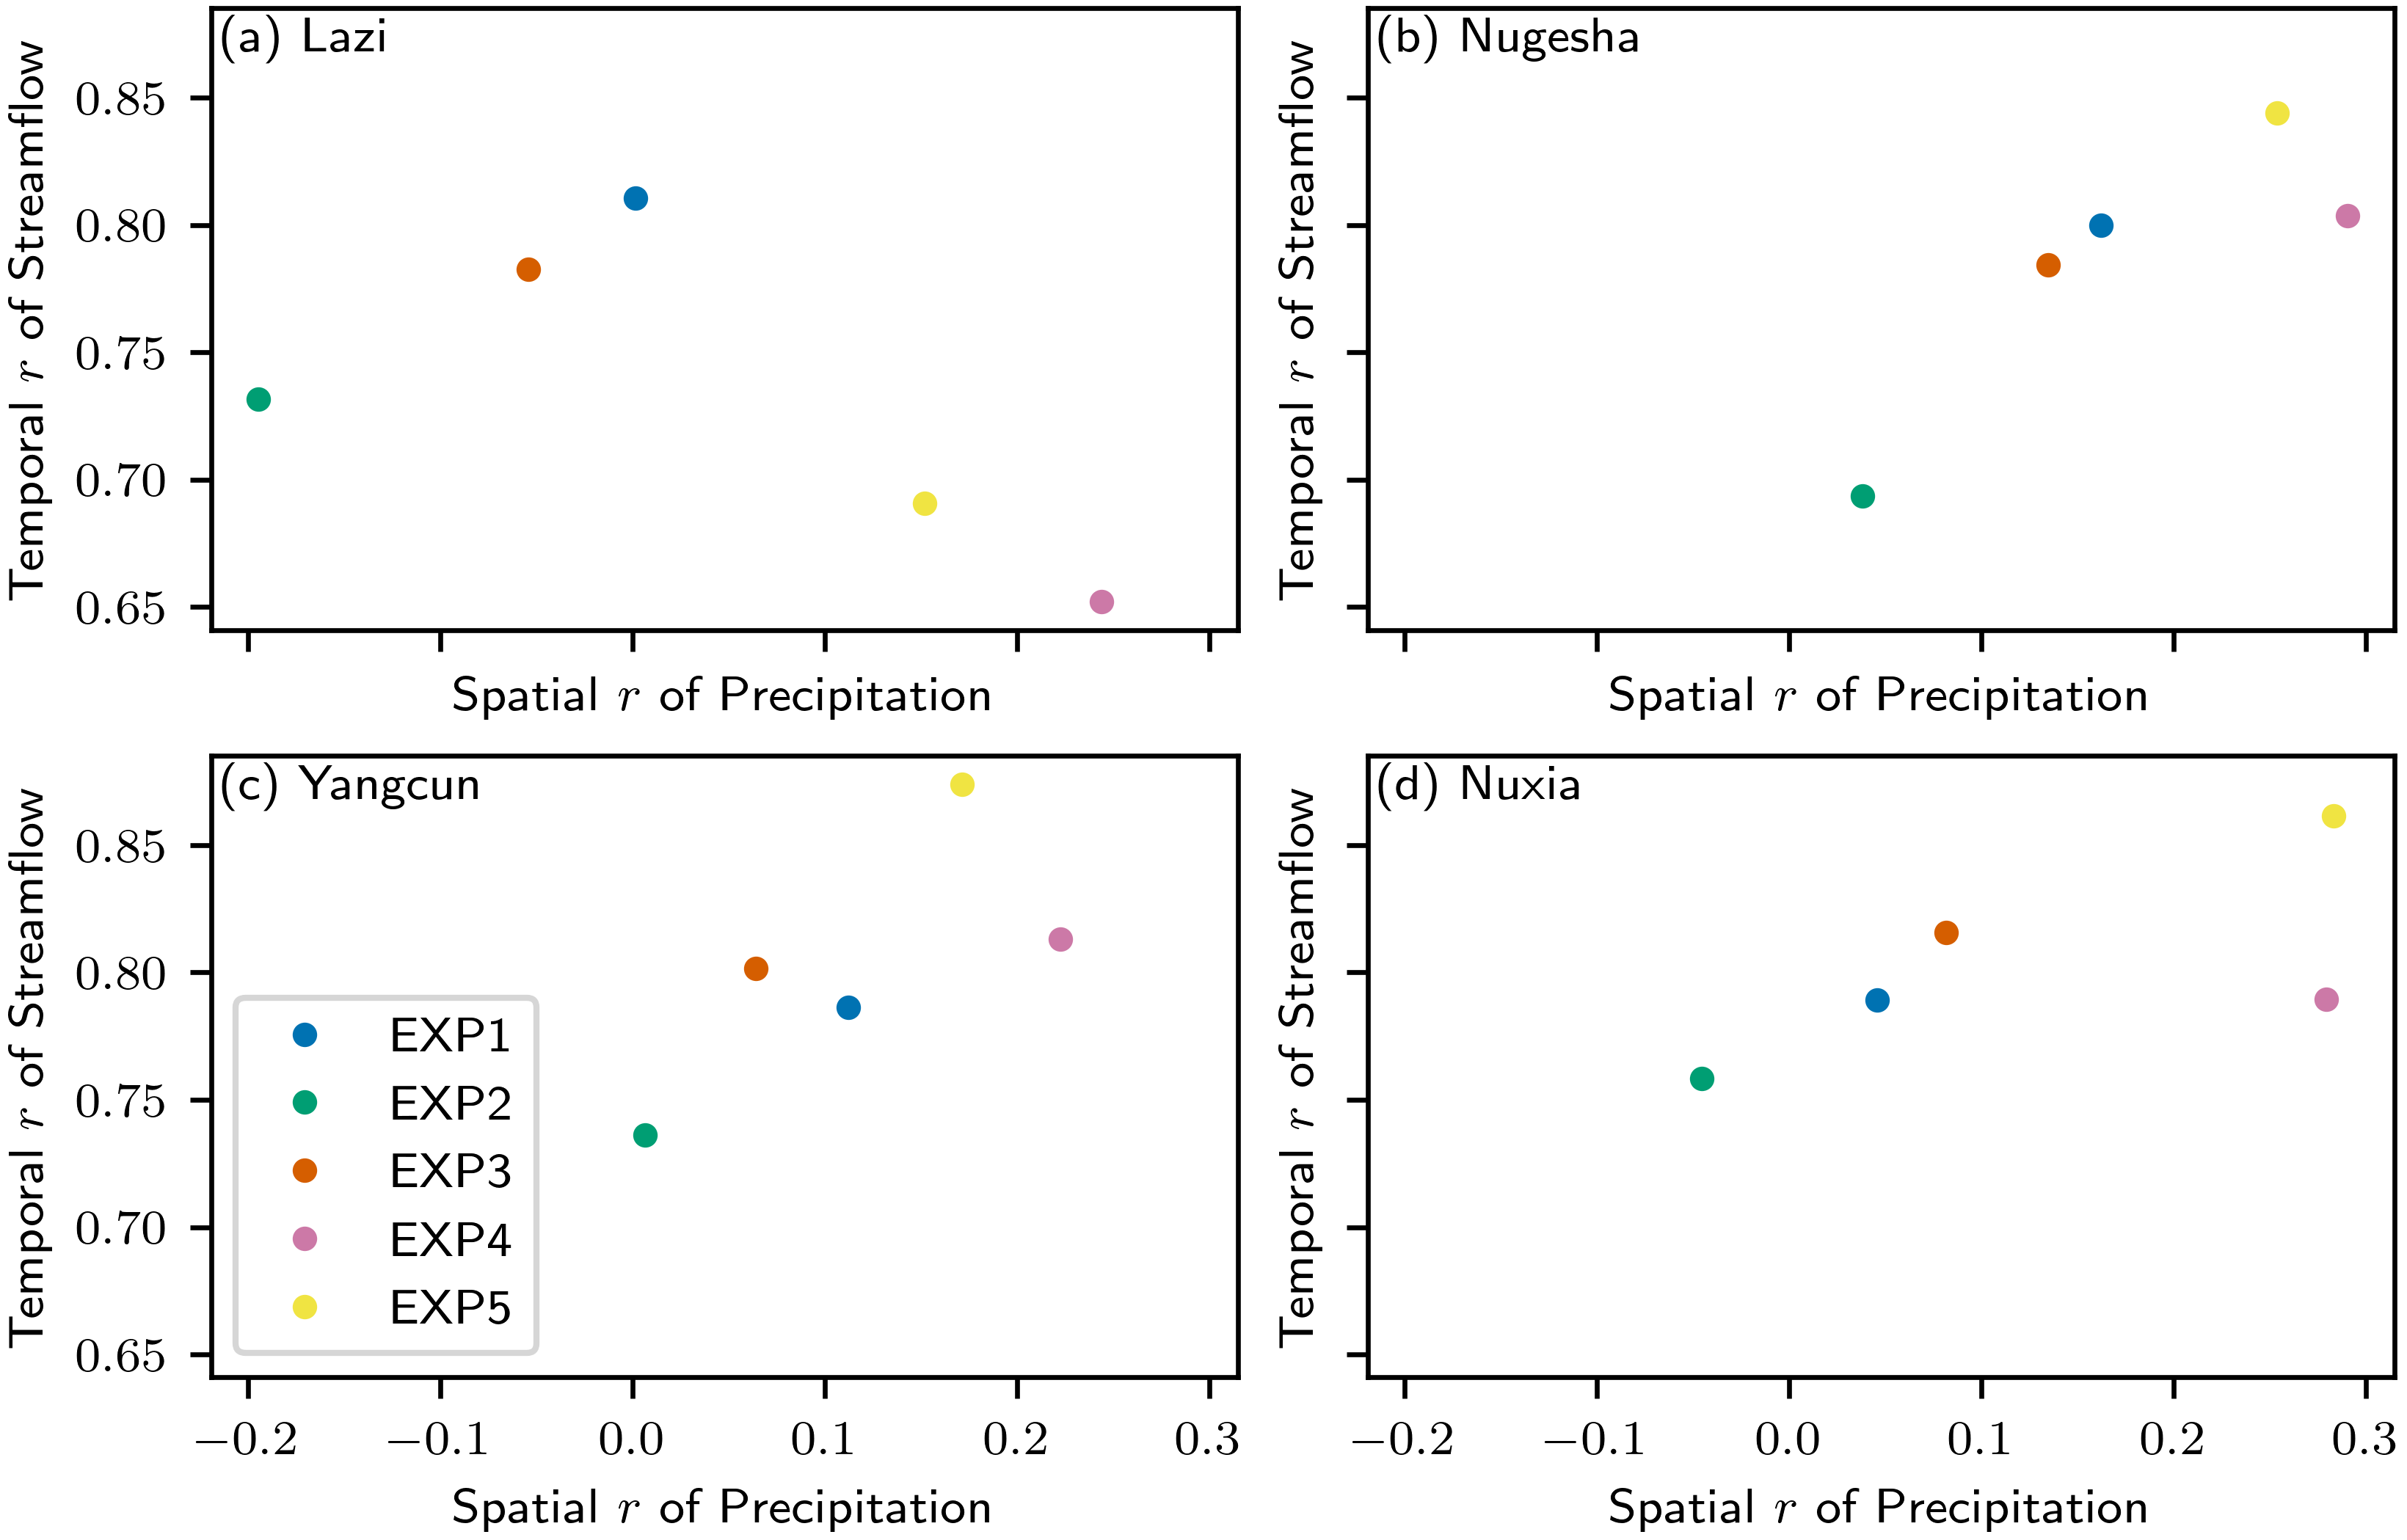

In [25]:
fig = plt.figure(figsize=(14/2.54, 9/2.54), dpi=FIGDPI, layout='constrained')
axs = fig.subplots(2, 2, sharex=True, sharey=True, squeeze=False)

labels = ['(a) Lazi', '(b) Nugesha', '(c) Yangcun', '(d) Nuxia']

for igauge, gaugename in enumerate(gaugenames):
    ax = axs.flat[igauge]
    for iens in range(NEXP):
        xx = prscc[gaugename][iens]
        idx = celerity[gaugename][iens].index(celerity_opt[iens, gaugename])
        yy = rnskills[gaugename][iens][idx].rho
        ax.plot(xx, yy, '.', label=f"EXP{iens+1}")
    ax.set_xlabel("Spatial $r$ of Precipitation")
    ax.set_ylabel("Temporal $r$ of Streamflow")
    ax.text(0.01, 0.99, labels[igauge], transform=ax.transAxes, fontsize=8, va='top', ha='left')

axs[1, 0].legend(fontsize=8)
fig.savefig(FIGROOT.joinpath("q_cc_p").with_suffix(FIGSUFFIX), bbox_inches='tight')

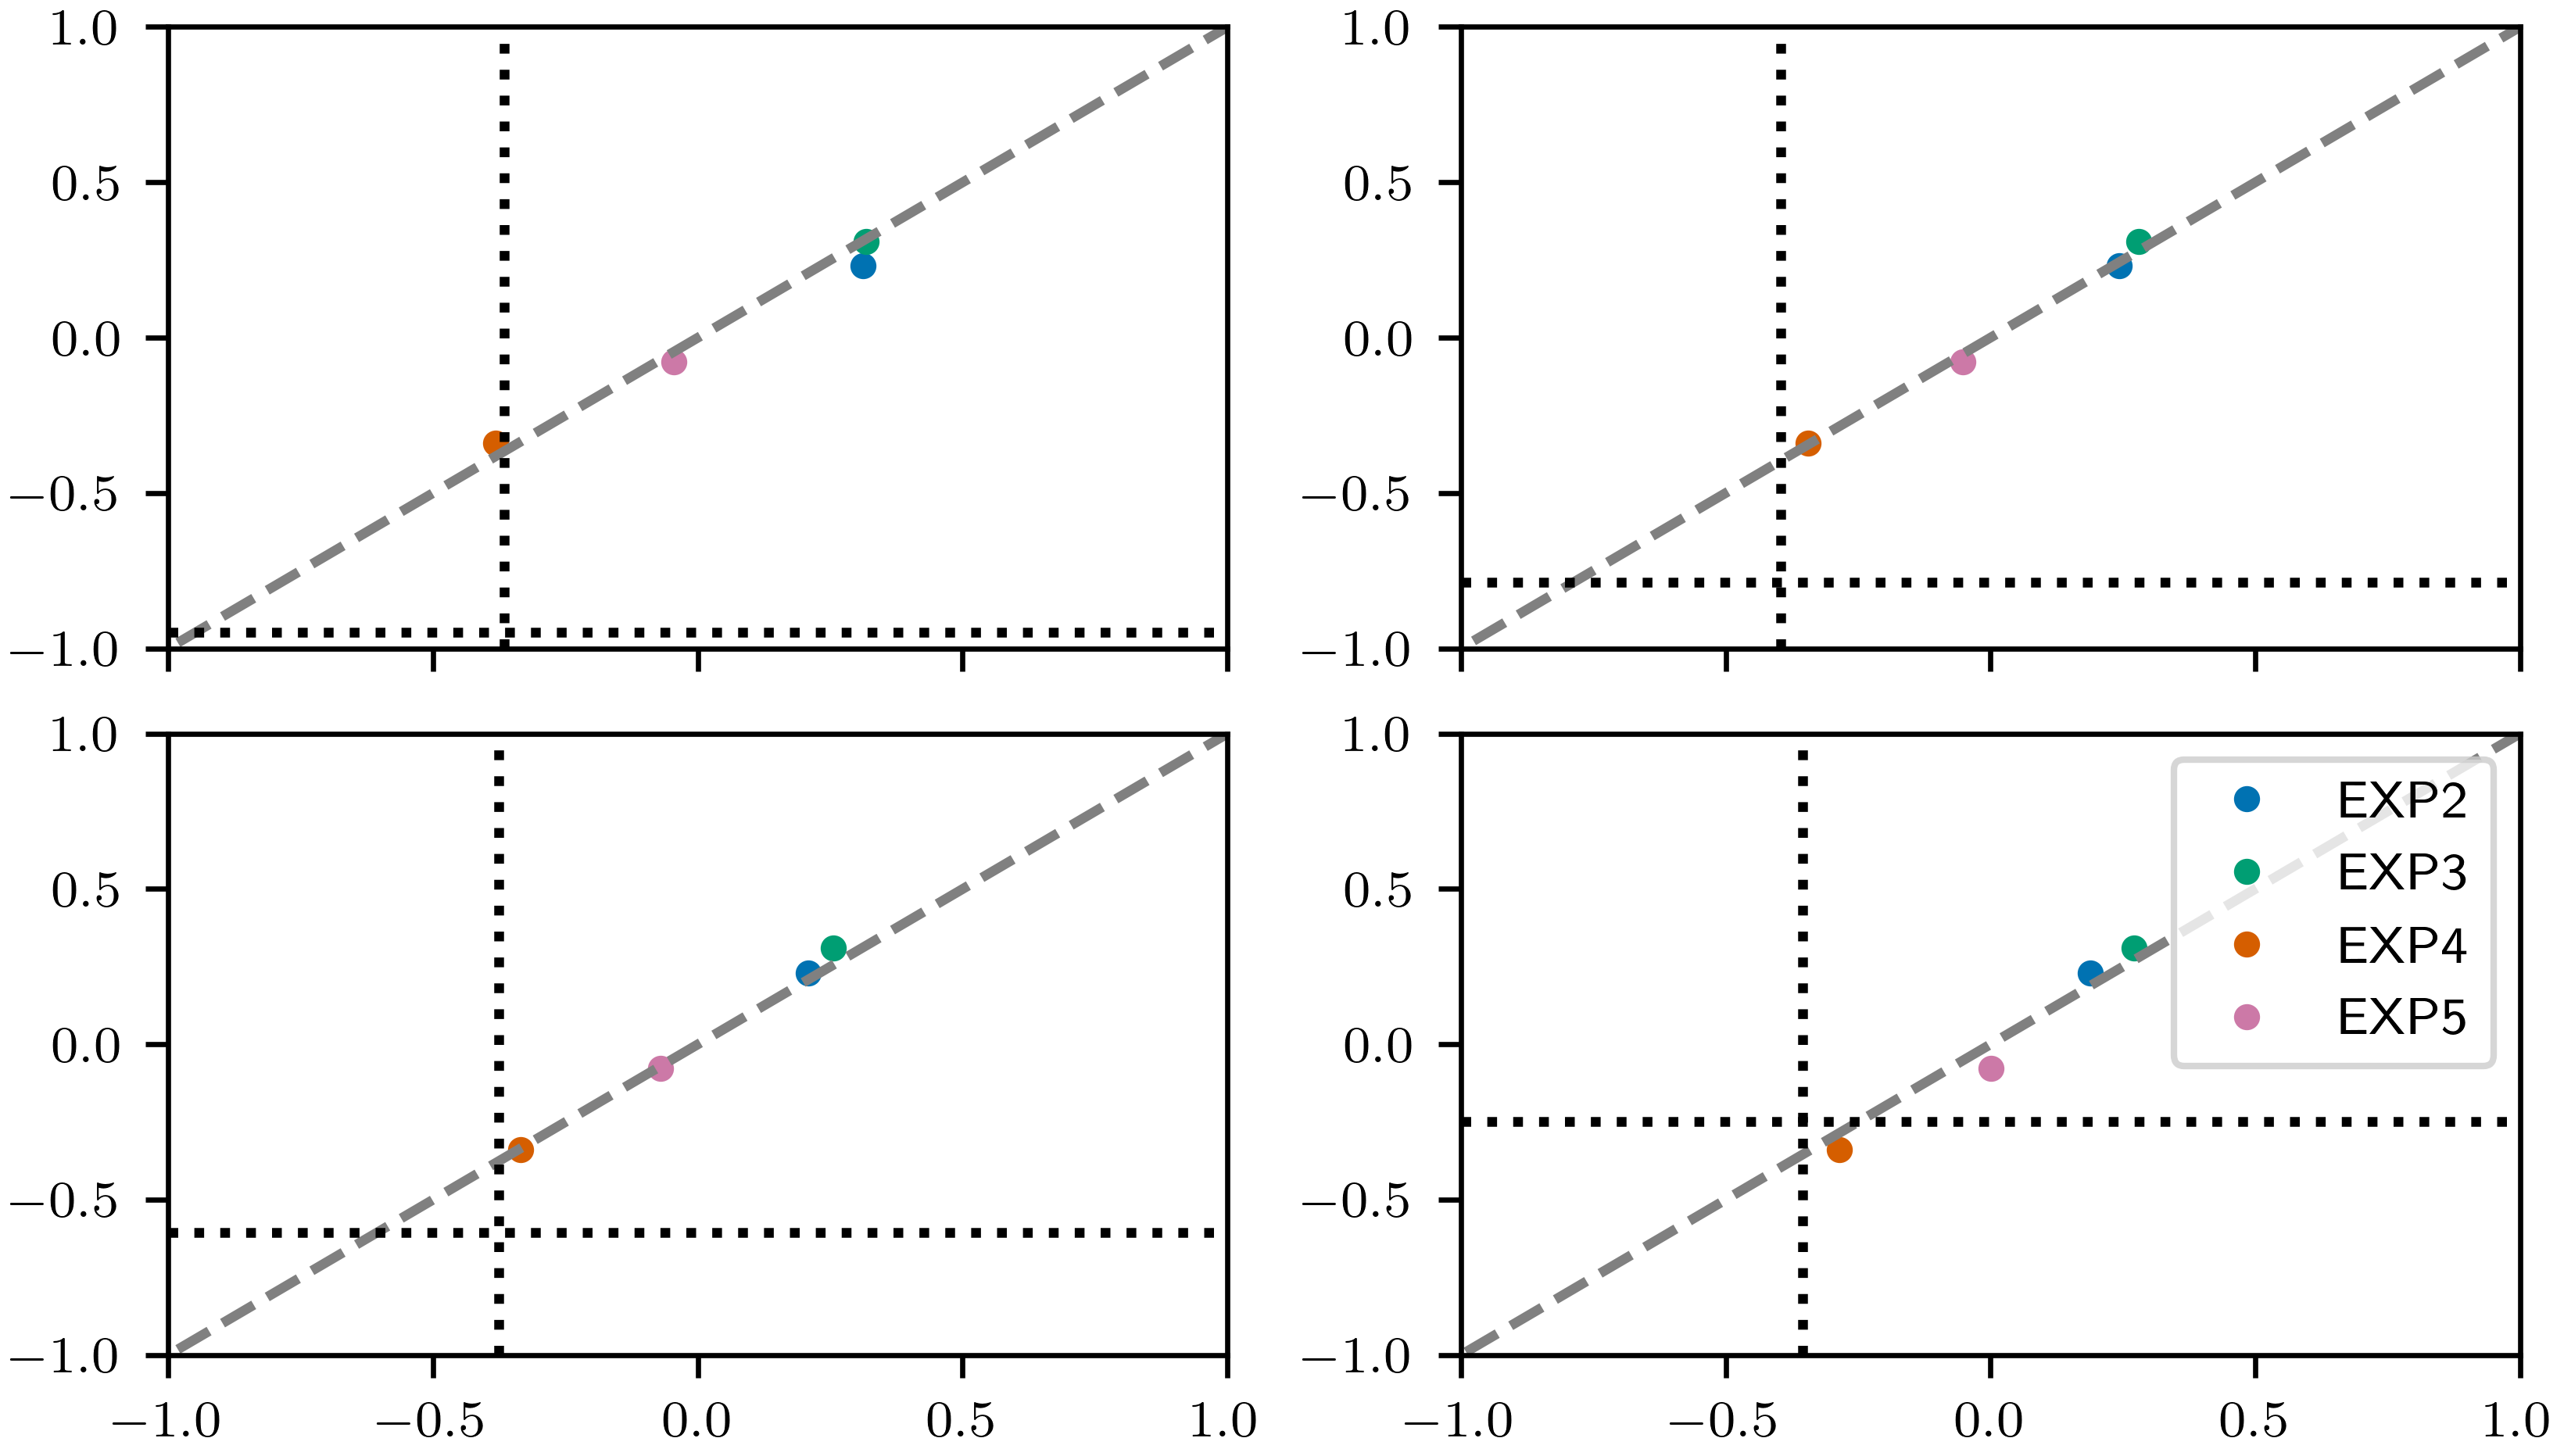

In [26]:
fig = plt.figure(figsize=(14/2.54, 8/2.54), dpi=FIGDPI, layout='constrained')
axs = fig.subplots(2, 2, sharex=True, squeeze=False)

labels = ['(a) Lazi', '(b) Nugesha', '(c) Yangcun', '(d) Nuxia']

for igauge, gaugename in enumerate(gaugenames):
    ax = axs.flat[igauge]
    xx = [x / sens_pr[gaugename][0] - 1 for x in sens_pr[gaugename]]
    # yy = [x / sens_rn[gaugename][0] - 1 for x in sens_rn[gaugename]]
    # ax.plot(xx, yy, 'k.')
    zz = [x / sens_sf[gaugename][0] - 1 for x in sens_sf[gaugename]]
    for iens in range(1, NEXP):
        ax.plot(xx[iens], zz[iens], '.', label=f"EXP{iens+1}")
    xx_gpm = sens_gpm[gaugename] / sens_pr[gaugename][0] - 1
    yy_sfo = sens_sfo[gaugename] / sens_sf[gaugename][0] - 1
    ax.plot([-1, 1], [-1, 1], transform=ax.transAxes, color='gray', linestyle='--')
    ax.plot([xx_gpm, xx_gpm], [-1, 1], 'k:')
    ax.plot([-1, 1], [yy_sfo, yy_sfo], 'k:')
    ax.set_xlim(-1.0, 1.0)
    ax.set_ylim(-1.0, 1.0)
ax.legend()


# Supplemetary materials

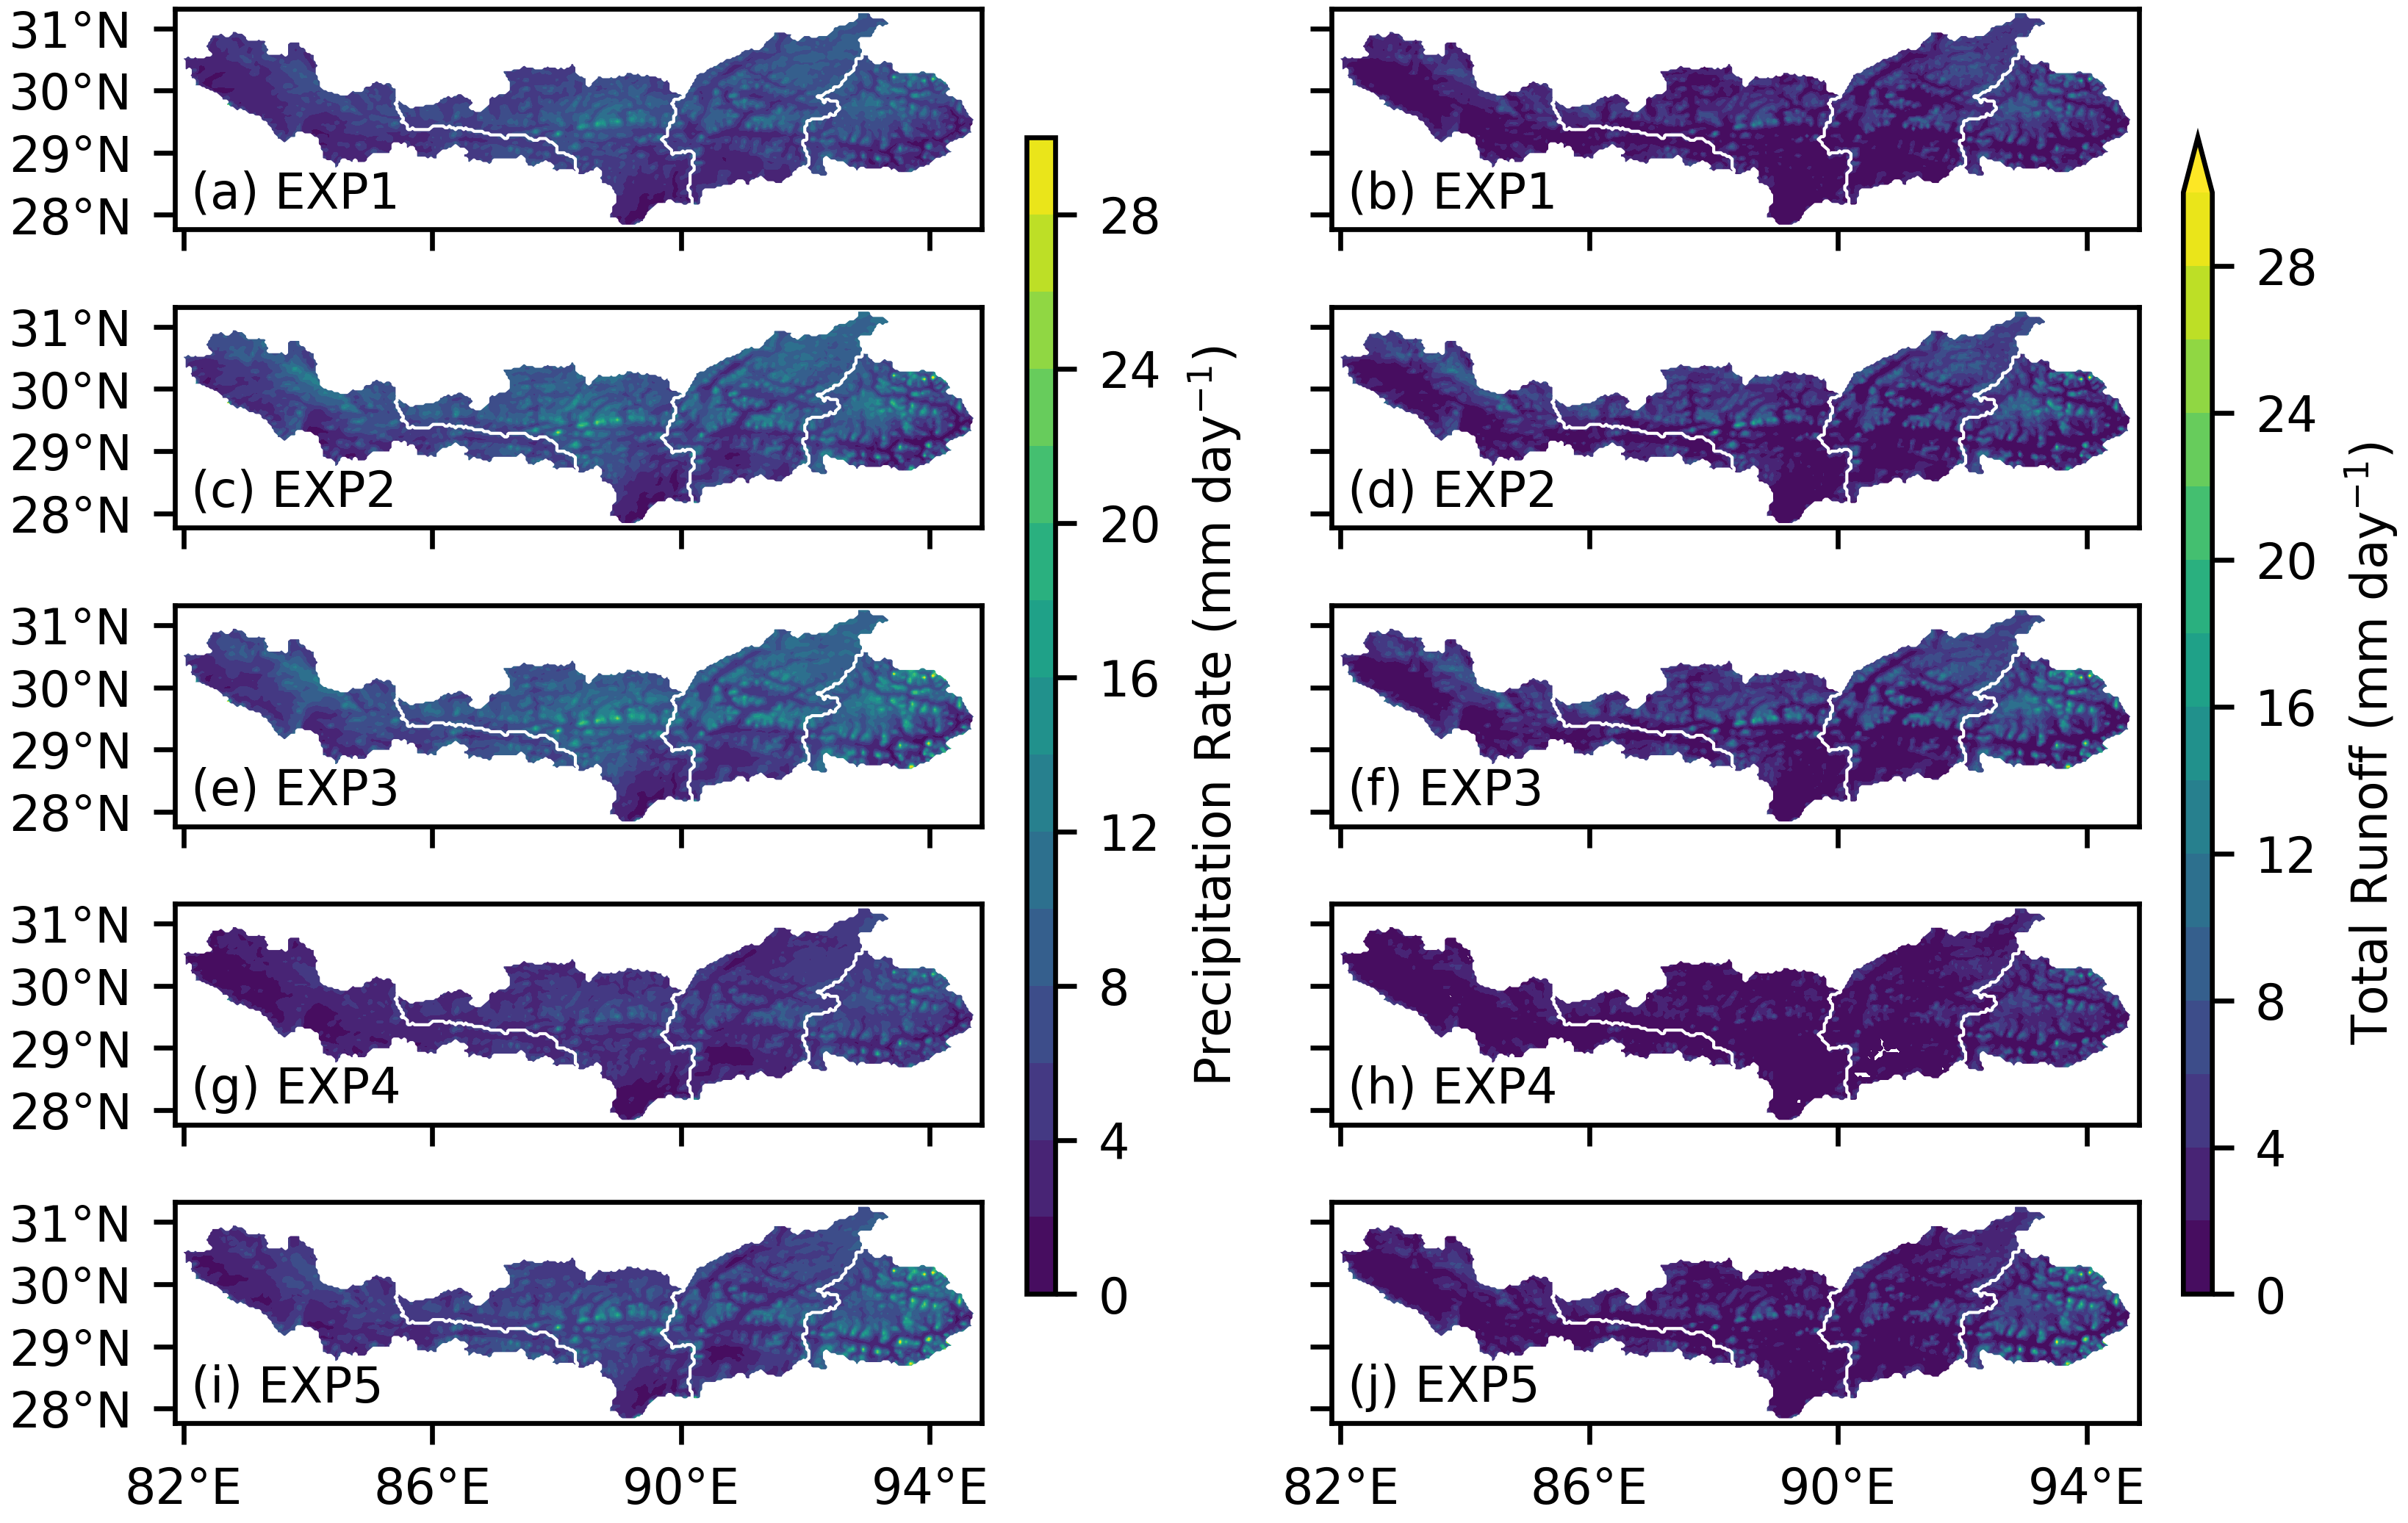

In [ ]:
fig = plt.figure(figsize=(14/2.54, 9/2.54), dpi=FIGDPI, layout='constrained')
axs = fig.subplots(5, 2, sharex=True, sharey=True, squeeze=False)

levels = np.arange(0, 32, 2)

for iens in range(5):
    ax = axs[iens, 0]
    cfp = ax.contourf(lon, lat, prrn['pr'].sel(ensemble=iens).mean('time') * (3600 * 24), levels=levels)
    ax.text(0.02, 0.05, f"({string.ascii_lowercase[iens * 2]}) EXP{iens+1}", fontsize=8, transform=ax.transAxes, va='bottom', ha='left')
    plot_yj(ax)

    ax = axs[iens, 1]
    cfr = ax.contourf(lon, lat, prrn['mrro'].sel(ensemble=iens).mean('time') * (3600 * 24), levels=levels, extend='max')
    ax.text(0.02, 0.05, f"({string.ascii_lowercase[iens * 2 + 1]}) EXP{iens+1}", fontsize=8, transform=ax.transAxes, va='bottom', ha='left')
    plot_yj(ax)


plt.colorbar(cfp, ax=axs[:, 0], label="Precipitation Rate (mm day$^{-1}$)", shrink=0.8, aspect=40)

plt.colorbar(cfr, ax=axs[:, 1], label="Total Runoff (mm day$^{-1}$)", shrink=0.8, aspect=40)

fig.savefig(FIGROOT.joinpath("prrn_dist").with_suffix(FIGSUFFIX), bbox_inches='tight')

In [ ]:
# mask_imbalance = prrn['mrro'].mean('time') > prrn['pr'].mean('time')
# mask_imbalance.name = 'mask_imbalance'
# mask_imbalance.to_netcdf(DATAROOT.joinpath("mask_imbalance.nc"))
# mask_imbalance = prrn['mrro'].mean('time').to_numpy() > prrn['pr'].mean('time').to_numpy()

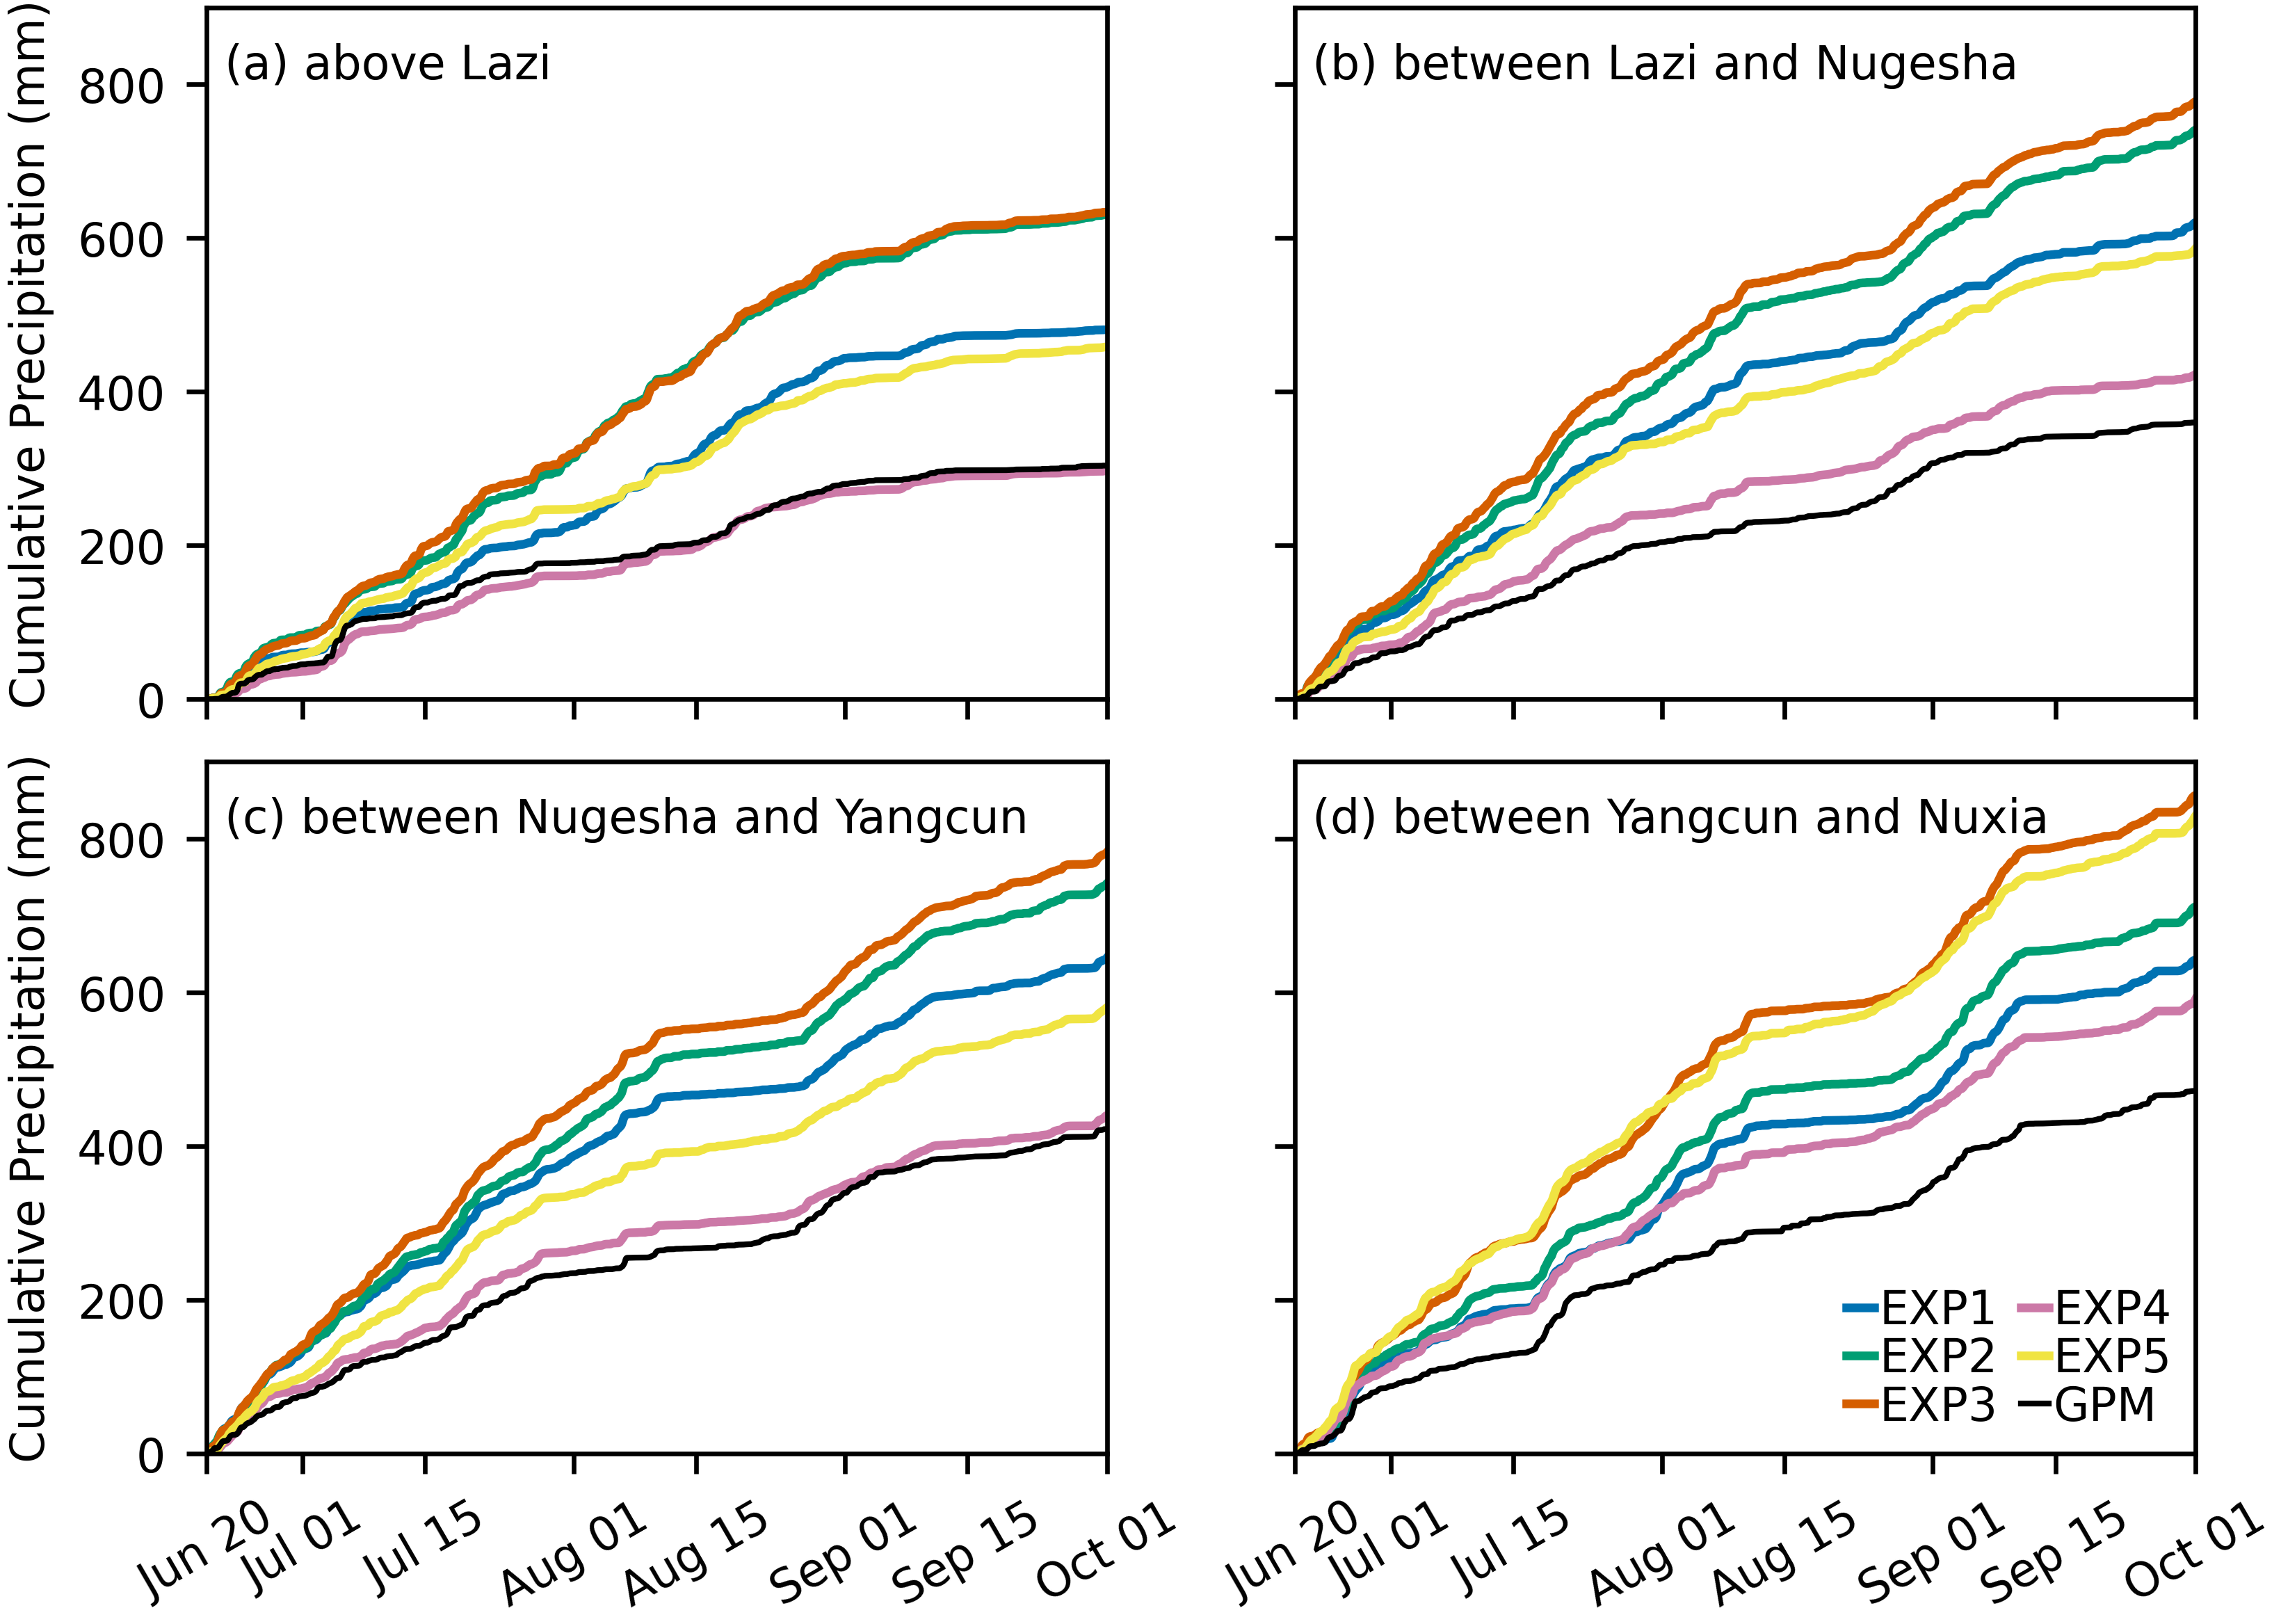

In [ ]:
fig = plt.figure(figsize=(14/2.54, 10/2.54), dpi=FIGDPI, layout='constrained')
axs = fig.subplots(2, 2, sharex=True, sharey=True, squeeze=False)

labels = ["(a) above Lazi", "(b) between Lazi and Nugesha", "(c) between Nugesha and Yangcun", "(d) between Yangcun and Nuxia"]

for igauge in range(4):
    ax = axs[igauge//2, igauge % 2]
    for iens in range(5):
        ax.plot(prrn['time'], prrn['pr'].sel(ensemble=iens).where(np.expand_dims(mask==igauge+1, axis=0)).mean(['lat', 'lon']).cumsum('time') * 3600.0, label=f"EXP{iens+1}")
    ax.plot(prrn['time'], prrn['gpm'].where(np.expand_dims(mask==igauge+1, axis=0)).mean(['lat', 'lon']).cumsum('time') * 3600.0, color='k', linewidth=1, label="GPM")

    ax.set_xlim(DATETIME_START, DATETIME_STOP)
    ax.set_ylim(0, 900)
    ax.xaxis.set_tick_params(rotation=30)
    ax.xaxis.set_ticks([datetime(2013, 6, 20), datetime(2013, 7, 1), datetime(2013, 7, 15), datetime(2013, 8, 1), datetime(2013, 8, 15), datetime(2013, 9, 1), datetime(2013, 9,15), datetime(2013, 10, 1)])
    ax.xaxis.set_ticklabels(["Jun 20", "Jul 01", "Jul 15", "Aug 01", "Aug 15", "Sep 01", "Sep 15", "Oct 01"])

    ax.text(0.02, 0.95, labels[igauge], transform=ax.transAxes, fontsize=8, va='top', ha='left')


axs[0, 0].set_ylabel("Cumulative Precipitation (mm)")
axs[1, 0].set_ylabel("Cumulative Precipitation (mm)")
axs[1, 1].legend(loc='lower right', ncol=2, columnspacing=0.5, borderpad=0.01, labelspacing=0.05, handlelength=0.6, handletextpad=0.1, frameon=False, fontsize=8)

fig.savefig(FIGROOT.joinpath("prrn_prcumsegts").with_suffix(FIGSUFFIX), bbox_inches='tight')

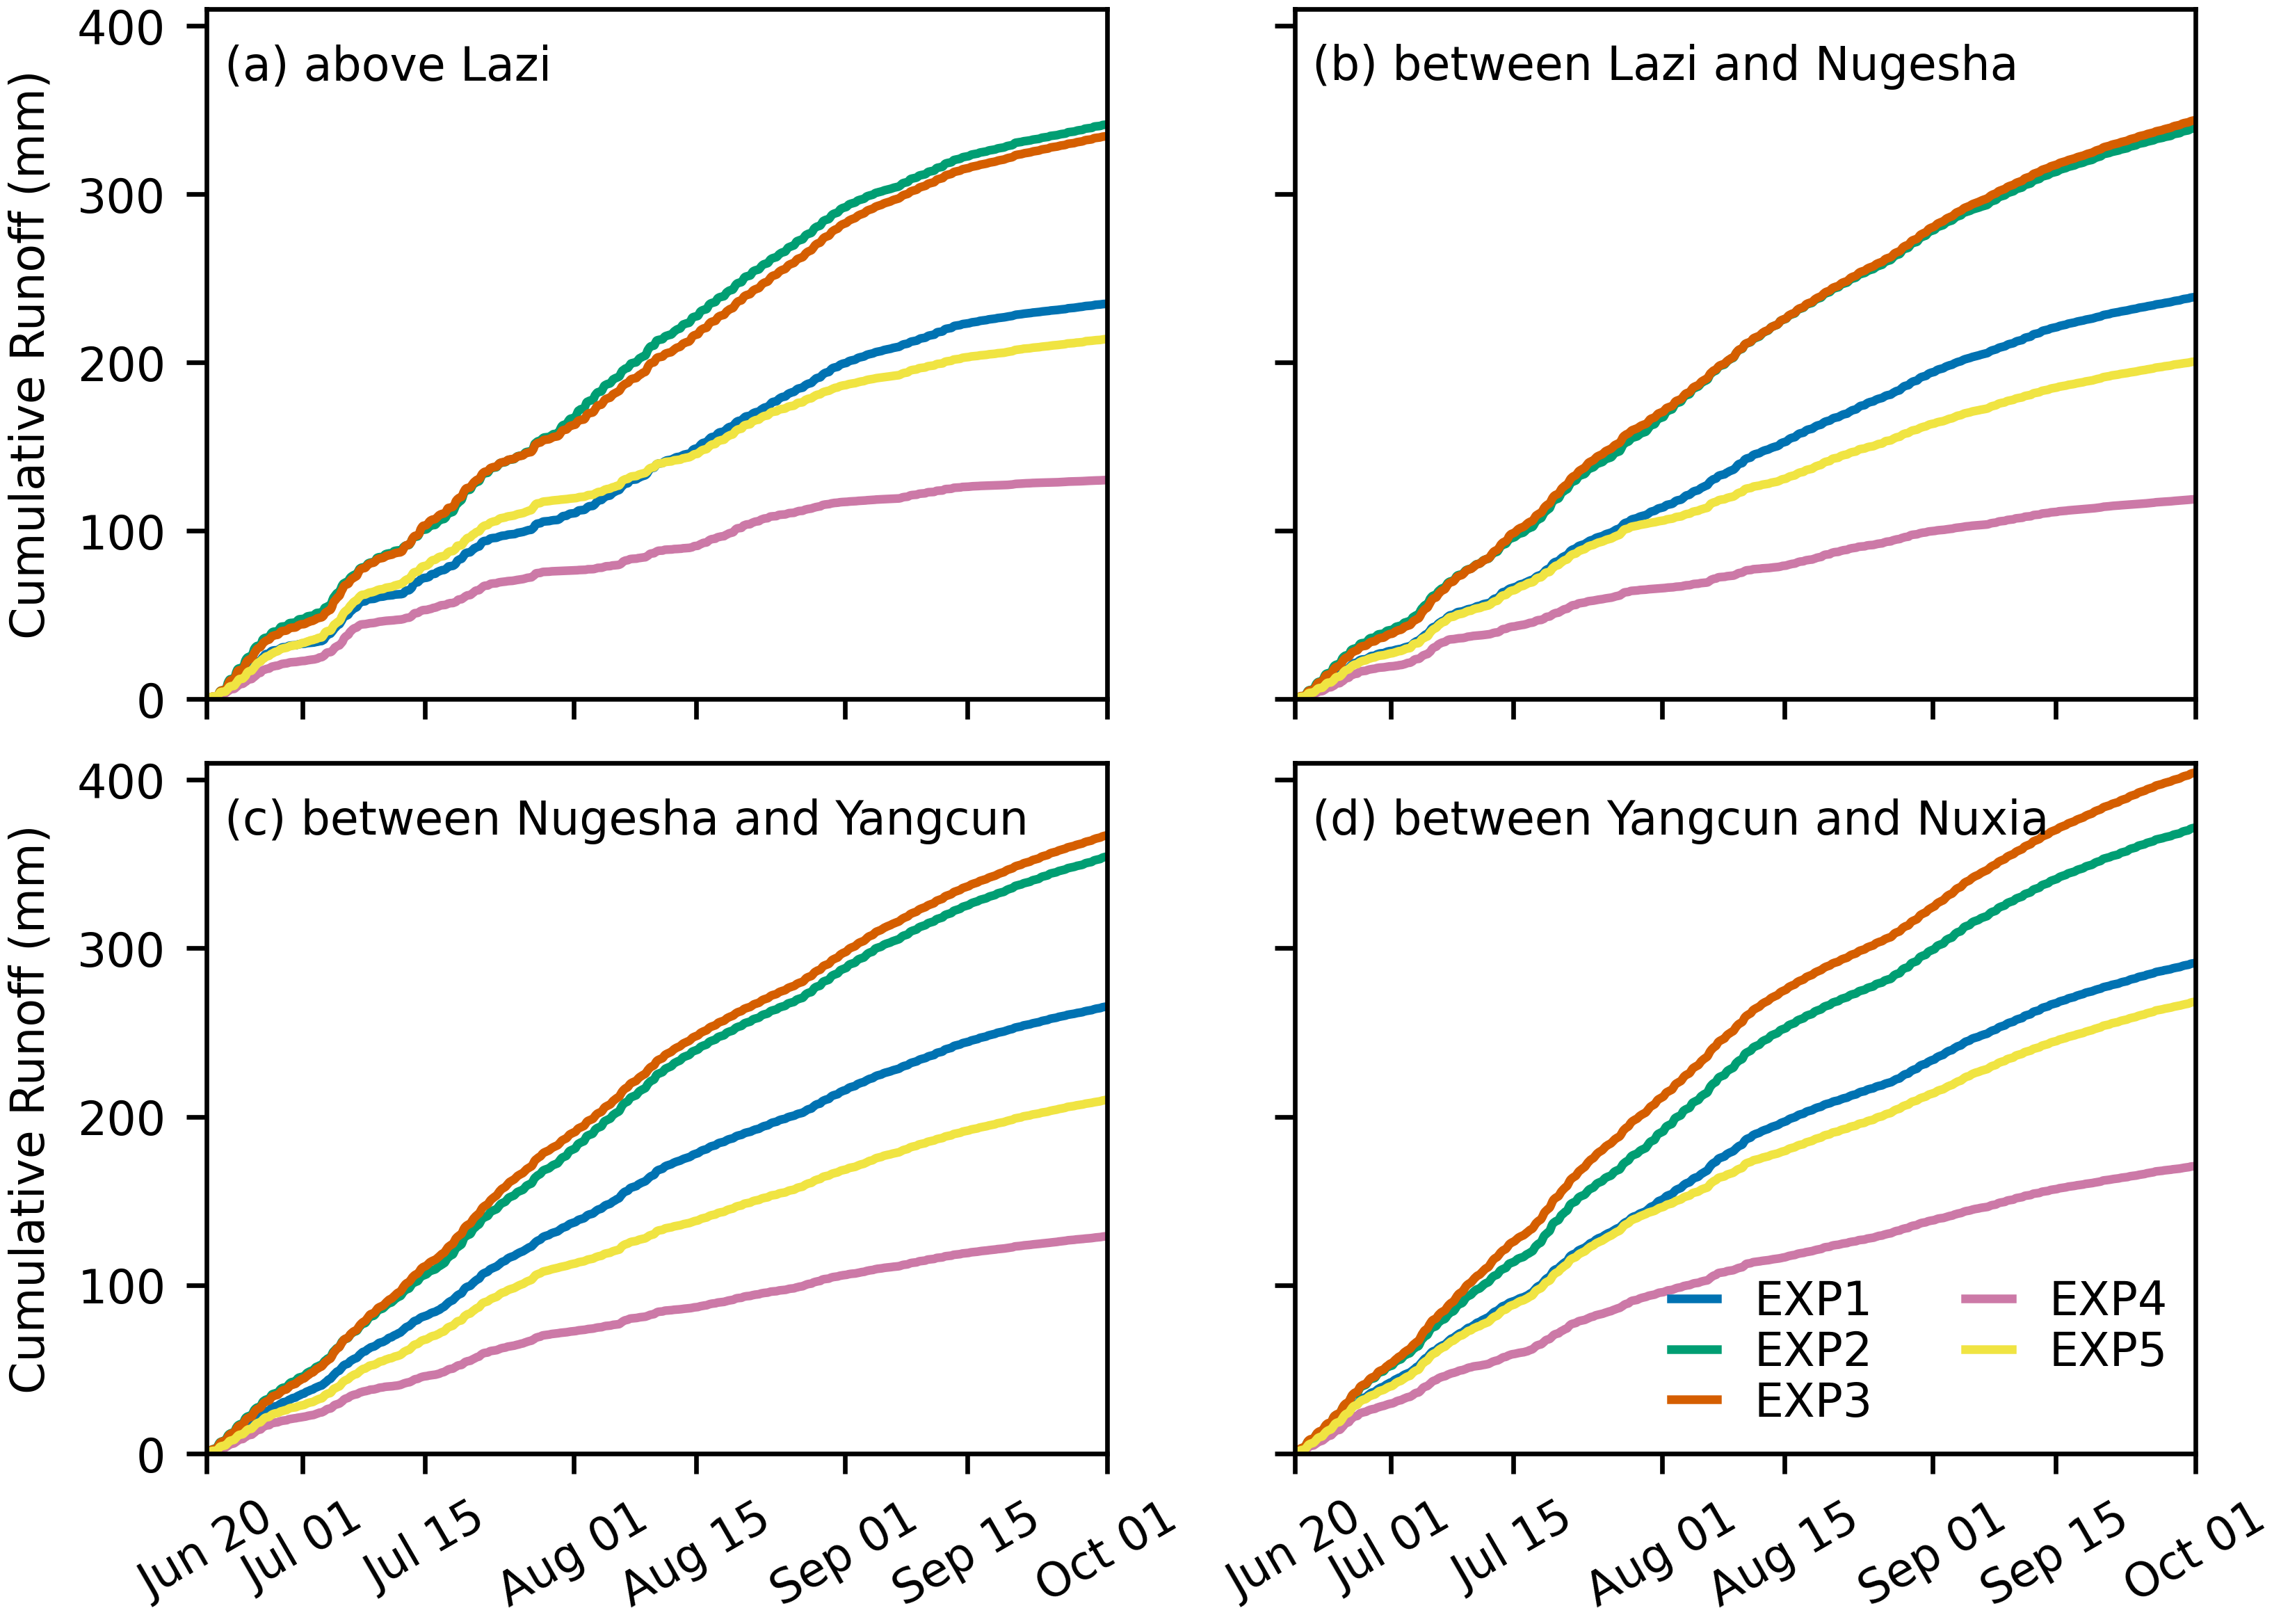

In [ ]:
fig = plt.figure(figsize=(14/2.54, 10/2.54), dpi=FIGDPI, layout='constrained')
axs = fig.subplots(2, 2, sharex=True, sharey=True, squeeze=False)

labels = ["(a) above Lazi", "(b) between Lazi and Nugesha", "(c) between Nugesha and Yangcun", "(d) between Yangcun and Nuxia"]

for igauge in range(4):
    ax = axs[igauge//2, igauge % 2]
    for iens in range(5):
        ax.plot(prrn['time'], prrn['mrro'].sel(ensemble=iens).where(np.logical_and(mask>0, mask<=igauge+1)).mean(['lat', 'lon']).cumsum() * 3600.0, label=f"EXP{iens+1}")

    ax.set_xlim(DATETIME_START, DATETIME_STOP)
    ax.set_ylim(0, 410)
    ax.xaxis.set_tick_params(rotation=30)
    ax.xaxis.set_ticks([datetime(2013, 6, 20), datetime(2013, 7, 1), datetime(2013, 7, 15), datetime(2013, 8, 1), datetime(2013, 8, 15), datetime(2013, 9, 1), datetime(2013, 9,15), datetime(2013, 10, 1)])
    ax.xaxis.set_ticklabels(["Jun 20", "Jul 01", "Jul 15", "Aug 01", "Aug 15", "Sep 01", "Sep 15", "Oct 01"])

    ax.text(0.02, 0.95, labels[igauge], transform=ax.transAxes, fontsize=8, va='top', ha='left')


axs[0, 0].set_ylabel("Cumulative Runoff (mm)")
axs[1, 0].set_ylabel("Cumulative Runoff (mm)")
axs[1, 1].legend(loc='lower right', ncol=2, borderpad=0.1, labelspacing=0.1, handlelength=1, frameon=False, fontsize=8, )

fig.savefig(FIGROOT.joinpath("prrn_rncumupts").with_suffix(FIGSUFFIX), bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(14/2.54, 10/2.54), dpi=FIGDPI, layout='constrained')
axs = fig.subplots(2, 2, sharex=True, squeeze=False)

labels = ['(a) Lazi', '(b) Nugesha', '(c) Yangcun', '(d) Nuxia']

for igauge, gaugename in enumerate(gaugenames):
    ax = axs.flat[igauge]
    for iens in range(5):
        ax.plot(celerity[stname][iens], [x.alpha for x in rnskills[stname][iens]], label=f"EXP{iens+1}")
    ax.set_xlabel("Celerity (m s$^{-1}$)")
    ax.set_ylabel("α")
    ax.text(0.01, 0.99, labels[igauge], transform=ax.transAxes, fontsize=8, va='top', ha='left')


ax.set_xlim(0.1, 6.0)
ax.set_xscale('log')

axs[1, 1].legend(loc='lower right', ncol=2, columnspacing=0.8, borderpad=0.01, labelspacing=0.05, handlelength=0.8, handletextpad=0.2, frameon=False, fontsize=8, )

fig.savefig(FIGROOT.joinpath("q_sens_alpha").with_suffix(FIGSUFFIX), bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(14/2.54, 10/2.54), dpi=FIGDPI, layout='constrained')
axs = fig.subplots(2, 2, sharex=True, squeeze=False)

labels = ['(a) Lazi', '(b) Nugesha', '(c) Yangcun', '(d) Nuxia']

for igauge, gaugename in enumerate(gaugenames):
    ax = axs.flat[igauge]
    for iens in range(5):
        ax.plot(celerity[gaugename][iens], [x.beta for x in rnskills[gaugename][iens]], label=f"EXP{iens+1}")
    ax.set_xlabel("Celerity (m s$^{-1}$)")
    ax.set_ylabel("β")
    ax.text(0.01, 0.99, labels[igauge], transform=ax.transAxes, fontsize=8, va='top', ha='left')


ax.set_xlim(0.1, 6.0)
ax.set_xscale('log')

axs[1, 1].legend(loc='lower right', ncol=2, columnspacing=0.8, borderpad=0.01, labelspacing=0.05, handlelength=0.8, handletextpad=0.2, frameon=False, fontsize=8, )

fig.savefig(FIGROOT.joinpath("q_sens_beta").with_suffix(FIGSUFFIX), bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(14/2.54, 10/2.54), dpi=FIGDPI, layout='constrained')
axs = fig.subplots(2, 2, sharex=True, squeeze=False)

labels = ['(a) Lazi', '(b) Nugesha', '(c) Yangcun', '(d) Nuxia']

for igauge, gaugename in enumerate(gaugenames):
    ax = axs.flat[igauge]
    for iens in range(5):
        ax.plot(celerity[gaugename][iens], [x.kge for x in rnskills[gaugename][iens]], label=f"EXP{iens+1}")
    ax.set_xlabel("Celerity (m s$^{-1}$)")
    ax.set_ylabel("KGE")
    ax.text(0.01, 0.99, labels[igauge], transform=ax.transAxes, fontsize=8, va='top', ha='left')


ax.set_xlim(0.1, 6.0)
ax.set_xscale('log')

axs[0, 0].set_ylim(-10, 1)
axs[0, 0].set_yticks(np.arange(-9, 1.1, 1))
axs[0, 1].set_ylim(-1.5, 1)
axs[1, 0].set_ylim(-1.3, 1)
axs[1, 1].set_ylim(-0.5, 1)
axs[1, 1].legend(loc='upper left', ncol=2, columnspacing=0.8, borderpad=1.2, labelspacing=0.05, handlelength=0.8, handletextpad=0.2, frameon=False, fontsize=8, )

fig.savefig(FIGROOT.joinpath("q_sens_kge").with_suffix(FIGSUFFIX), bbox_inches='tight')

In [ ]:
prrn.close()